%md
# Membrete - Unificación de Archivos del ICFES.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6c/Javeriana.svg" alt="Logo Javeriana" width="150"/>

- **Nombres:** Alberto Luis Vigna Arroyo, Andrés Salamanca, Alejandro Salamanca.
- **Universidad:** Pontificia Universidad Javeriana.
- **Materia:** Procesamiento de Datos a Gran Escala.
- **Nombre del Profesor:** John Corredor.
- **Correo Electrónico:** a-vigna@javeriana.edu.co, salamanca-andres@javeriana.edu.co, al_salamanca@javeriana.edu.co.
- **Fecha:** 07 de mayo de 2024.
- **Lugar:** Bogotá, Colombia.

%md
#1. Cargar las bibliotecas necesarias y la sesión PySpark:

In [0]:
pip install pyarrow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext , Row, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType,FloatType
from pyspark.ml.feature import DenseVector,StandardScaler,VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Pandas
import pandas as pd

# MatPlotLib
import matplotlib.pyplot as plt

%md
# 2. Creación de los dataframes:
###Creación de los dataframes de PySpark de cada uno de los años.

In [0]:
# Se levanta la sesión de PySpart, para hacer uso de los métodos y herramientas que dispone.
spark = SparkSession.builder.appName("Investigación de Resultados ICFES").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

sql_sc = SQLContext(spark)

spark

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


##2.1 Unificación de Archivos:

#### Debido a que durante los segundos periodos de presentación del ICFES (todos aquellos terminados en -2) suelen tener una asistencia muchísimo mayor, el archivo de resultados suele ser muchísimo más grande.

Para solucionar este problema decidimos partir cada uno de esos resultados por años y cada año separarlo en 5 partes para luego unificarlas directamente en el código.

In [0]:
# Encabezado de los datos (nombre de las columnas completos)
header = [
    "ESTU_TIPODOCUMENTO", "ESTU_NACIONALIDAD", "ESTU_GENERO", "ESTU_FECHANACIMIENTO",
    "PERIODO", "ESTU_CONSECUTIVO", "ESTU_ESTUDIANTE", "ESTU_PAIS_RESIDE", "ESTU_DEPTO_RESIDE",
    "ESTU_COD_RESIDE_DEPTO", "ESTU_MCPIO_RESIDE", "ESTU_COD_RESIDE_MCPIO", "ESTU_PRESENTACIONSABADO",
    "ESTU_LENGUANATIVA", "FAMI_ESTRATOVIVIENDA", "FAMI_PERSONASHOGAR", "FAMI_CUARTOSHOGAR",
    "FAMI_EDUCACIONPADRE", "FAMI_EDUCACIONMADRE", "FAMI_TRABAJOLABORPADRE", "FAMI_TRABAJOLABORMADRE",
    "FAMI_TIENEINTERNET", "FAMI_TIENECOMPUTADOR", "FAMI_TIENELAVADORA", "FAMI_TIENEHORNOMICROOGAS",
    "FAMI_TIENESERVICIOTV", "FAMI_TIENEAUTOMOVIL", "FAMI_TIENEMOTOCICLETA", "FAMI_TIENECONSOLAVIDEOJUEGOS",
    "FAMI_NUMLIBROS", "FAMI_COMELECHEDERIVADOS", "FAMI_COMECARNEPESCADOHUEVO", "FAMI_COMECEREALFRUTOSLEGUMBRE",
    "FAMI_SITUACIONECONOMICA", "ESTU_DEDICACIONLECTURADIARIA", "ESTU_DEDICACIONINTERNET",
    "ESTU_HORASSEMANATRABAJA", "ESTU_TIPOREMUNERACION", "COLE_CODIGO_ICFES", "COLE_COD_DANE_ESTABLECIMIENTO",
    "COLE_NOMBRE_ESTABLECIMIENTO", "COLE_GENERO", "COLE_NATURALEZA", "COLE_CALENDARIO",
    "COLE_BILINGUE", "COLE_CARACTER", "COLE_COD_DANE_SEDE", "COLE_NOMBRE_SEDE", "COLE_SEDE_PRINCIPAL",
    "COLE_AREA_UBICACION", "COLE_JORNADA", "COLE_COD_MCPIO_UBICACION", "ESTU_GENERACION",
    "COLE_MCPIO_UBICACION", "COLE_COD_DEPTO_UBICACION", "COLE_DEPTO_UBICACION", "ESTU_PRIVADO_LIBERTAD",
    "ESTU_COD_MCPIO_PRESENTACION", "ESTU_MCPIO_PRESENTACION", "ESTU_DEPTO_PRESENTACION",
    "ESTU_COD_DEPTO_PRESENTACION", "PUNT_LECTURA_CRITICA", "PERCENTIL_LECTURA_CRITICA",
    "DESEMP_LECTURA_CRITICA", "PUNT_MATEMATICAS", "PERCENTIL_MATEMATICAS", "DESEMP_MATEMATICAS",
    "PUNT_C_NATURALES", "PERCENTIL_C_NATURALES", "DESEMP_C_NATURALES", "PUNT_SOCIALES_CIUDADANAS",
    "PERCENTIL_SOCIALES_CIUDADANAS", "DESEMP_SOCIALES_CIUDADANAS", "PUNT_INGLES",
    "PERCENTIL_INGLES", "DESEMP_INGLES", "PUNT_GLOBAL", "PERCENTIL_GLOBAL",
    "PERCENTIL_ESPECIAL_GLOBAL", "ESTU_INSE_INDIVIDUAL", "ESTU_NSE_INDIVIDUAL",
    "ESTU_NSE_ESTABLECIMIENTO", "ESTU_ESTADOINVESTIGACION"
]

print("Header de los datos: \n", header)

Header de los datos: 
 ['ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO', 'ESTU_FECHANACIMIENTO', 'PERIODO', 'ESTU_CONSECUTIVO', 'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_DEPTO_RESIDE', 'ESTU_COD_RESIDE_DEPTO', 'ESTU_MCPIO_RESIDE', 'ESTU_COD_RESIDE_MCPIO', 'ESTU_PRESENTACIONSABADO', 'ESTU_LENGUANATIVA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE', 'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'FAMI_TIENEHORNOMICROOGAS', 'FAMI_TIENESERVICIOTV', 'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS', 'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO', 'FAMI_COMECEREALFRUTOSLEGUMBRE', 'FAMI_SITUACIONECONOMICA', 'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'ESTU_TIPOREMUNERACION', 'COLE_CODIGO_ICFES', 'COLE_COD_DANE_ESTABLECIMIENTO', 'COLE_NOMBRE_ESTABL

###Creación de los dataframes: Año 2018-2.

In [0]:
# URLs de los archivos divididos
paths2018 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-2/particiones_SB11_20182/SB11_20182_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-2/particiones_SB11_20182/SB11_20182_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-2/particiones_SB11_20182/SB11_20182_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-2/particiones_SB11_20182/SB11_20182_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-2/particiones_SB11_20182/SB11_20182_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2018:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2018_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2018_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_TIENEETNIA,ESTU_ETNIA,ESTU_LIMITA_MOTRIZ,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_SITUACIONECONOMICA,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,COLE_CODIGO_ICFES,...,COLE_NATURALEZA,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_JORNADA,COLE_COD_MCPIO_UBICACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,DESEMP_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,DESEMP_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_ESTADOINVESTIGACION,ESTU_GENERACION-E
0,CR,COLOMBIA,M,22/09/1999,20182,SB11201820540351,ESTUDIANTE,COLOMBIA,No,NaN,NaN,ATLANTICO,8.0,PIOJÓ,8549.0,Estrato 1,5 a 6,Cuatro,Ninguno,Primaria incompleta,"Trabaja en el hogar, no trabaja o estudia","Trabaja en el hogar, no trabaja o estudia",No,Si,Si,Si,Si,No,Si,Si,0 A 10 LIBROS,1 o 2 veces por semana,Todos o casi todos los días,1 o 2 veces por semana,Peor,No leo por entretenimiento,Más de 3 horas,0,No,107367,...,OFICIAL,A,N,ACADÉMICO,208549000045,INSTITUCION EDUCATIVA NIÑO JESUS DE PRAGA,S,RURAL,MAÑANA,8549,PIOJÓ,8,ATLANTICO,N,8638,SABANALARGA,ATLANTICO,8,40,12,2,30,4,1,39,18,1,30,5,1,42.0,25,A-,177,6,2.0,45.885859,NSE2,PUBLICAR,NO
1,TI,COLOMBIA,M,29/12/2000,20182,SB11201820059515,ESTUDIANTE,COLOMBIA,No,NaN,NaN,ANTIOQUIA,5.0,ARBOLETES,5051.0,Estrato 1,5 a 6,Tres,Primaria incompleta,Primaria incompleta,"Es agricultor, pesquero o jornalero",No sabe,No,Si,No,Si,No,No,No,No,0 A 10 LIBROS,1 o 2 veces por semana,3 a 5 veces por semana,3 a 5 veces por semana,Igual,Entre 1 y 2 horas,No Navega Internet,Entre 11 y 20 horas,"Si, en efectivo",142612,...,OFICIAL,A,NaN,ACADÉMICO,205051001339,COLEGIO EL CARMELO,S,RURAL,MAÑANA,5051,ARBOLETES,5,ANTIOQUIA,N,5051,ARBOLETES,ANTIOQUIA,5,43,20,2,40,21,2,40,19,1,36,15,1,41.0,22,A-,199,16,1.0,37.079030,NSE1,PUBLICAR,GENERACION E - GRATUIDAD
2,CC,COLOMBIA,F,22/04/1998,20182,SB11201820568196,ESTUDIANTE,COLOMBIA,No,NaN,NaN,ATLANTICO,8.0,BARRANQUILLA,8001.0,Estrato 2,1 a 2,Uno,Técnica o tecnológica completa,Secundaria (Bachillerato) incompleta,Trabaja por cuenta propia (por ejemplo plomero...,Es vendedor o trabaja en atención al público,No,No,No,Si,No,No,No,No,11 A 25 LIBROS,1 o 2 veces por semana,Todos o casi todos los días,1 o 2 veces por semana,Igual,30 minutos o menos,30 minutos o menos,Entre 21 y 30 horas,No,158337,...,NO OFICIAL,A,N,ACADÉMICO,308758077980,CENTRO EDUCATIVO SAN BERNARDO PARA ADULTOS,S,URBANO,NOCHE,8758,SOLEDAD,8,ATLANTICO,N,8001,BARRANQUILLA,ATLANTICO,8,38,7,2,34,10,1,41,23,2,30,4,1,38.0,14,A-,180,7,2.0,45.303861,NSE2,PUBLICAR,GENERACION E - GRATUIDAD
3,TI,COLOMBIA,F,30/05/2002,20182,SB11201820446686,ESTUDIANTE,COLOMBIA,No,NaN,NaN,ATLANTICO,8.0,SOLEDAD,8758.0,Estrato 1,5 a 6,Tres,Primaria completa,Técnica o tecnológica incompleta,Trabaja por cuenta propia (por ejemplo plomero...,"Trabaja como personal de limpieza, mantenimien...",No,No,Si,No,No,Si,No,No,0 A 10 LIBROS,1 o 2 vece

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2018_2)))

La cantidad de registros en el Data Frame es: 549934


###Creación de los dataframes: Año 2019-2.

In [0]:
# URLs de los archivos divididos
paths2019 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2019/2019-2/particiones_SB11_20192/SB11_20192_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2019/2019-2/particiones_SB11_20192/SB11_20192_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2019/2019-2/particiones_SB11_20192/SB11_20192_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2019/2019-2/particiones_SB11_20192/SB11_20192_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2019/2019-2/particiones_SB11_20192/SB11_20192_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2019:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2019_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2019_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_TIENEETNIA,ESTU_PAIS_RESIDE,ESTU_ETNIA,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_SITUACIONECONOMICA,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,COLE_CODIGO_ICFES,COLE_COD_DANE_ESTABLECIMIENTO,...,COLE_NATURALEZA,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_JORNADA,COLE_COD_MCPIO_UBICACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,DESEMP_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,DESEMP_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_ESTADOINVESTIGACION,ESTU_GENERACION-E
0,TI,COLOMBIA,M,18/02/2002,20194,SB11201940031558,ESTUDIANTE,No,COLOMBIA,NaN,MAGDALENA,47.0,SANTA ANA,47707.0,Estrato 3,5 a 6,Cinco,Educación profesional completa,Secundaria (Bachillerato) completa,No aplica,"Trabaja en el hogar, no trabaja o estudia",Si,Si,No,Si,Si,No,No,No,MÁS DE 100 LIBROS,1 o 2 veces por semana,3 a 5 veces por semana,Nunca o rara vez comemos eso,Peor,Entre 30 y 60 minutos,Entre 30 y 60 minutos,Menos de 10 horas,"Si, en efectivo",39008,147707000156,...,OFICIAL,A,N,TÉCNICO/ACADÉMICO,147707000156,COL DPTAL ANTONIO BRUGES CARMONA,S,URBANO,MAÑANA,47707,SANTA ANA,47,MAGDALENA,N,47707,SANTA ANA,MAGDALENA,47,47,33,2,48,42,2,37,15,1,30,8,1,54.0,67,A1,208,25.0,50.942156,2.0,2.0,PUBLICAR,NO
1,TI,COLOMBIA,F,24/01/2003,20194,SB11201940469859,ESTUDIANTE,No,COLOMBIA,NaN,SANTANDER,68.0,BUCARAMANGA,68001.0,NaN,3 a 4,Tres,NaN,NaN,Es vendedor o trabaja en atención al público,Es vendedor o trabaja en atención al público,NaN,NaN,Si,Si,Si,Si,No,Si,NaN,NaN,NaN,NaN,Igual,NaN,NaN,0,"Si, en efectivo",58206,368001000702,...,NO OFICIAL,A,N,TÉCNICO/ACADÉMICO,368001000702,INST SANTA MARIA MICAELA,S,URBANO,MAÑANA,68001,BUCARAMANGA,68,SANTANDER,N,68001,BUCARAMANGA,SANTANDER,68,61,80,3,41,22,2,60,85,3,59,83,3,64.0,89,A2,280,74.0,61.920976,3.0,3.0,PUBLICAR,NO
2,TI,COLOMBIA,M,28/06/2003,20194,SB11201940303339,ESTUDIANTE,No,COLOMBIA,NaN,BOGOTÁ,11.0,BOGOTÁ D.C.,11001.0,Estrato 3,9 o más,Tres,Técnica o tecnológica completa,Técnica o tecnológica completa,Trabaja por cuenta propia (por ejemplo plomero...,Es dueño de un negocio pequeño (tiene pocos em...,Si,Si,Si,Si,Si,Si,No,No,MÁS DE 100 LIBROS,Todos o casi todos los días,3 a 5 veces por semana,1 o 2 veces por semana,Mejor,Entre 30 y 60 minutos,Entre 30 y 60 minutos,Menos de 10 horas,"Si, en efectivo",128611,311001105383,...,NO OFICIAL,A,NaN,ACADÉMICO,311001105383,GIMN SAN ANGELO ...,S,URBANO,COMPLETA,11001,BOGOTÁ D.C.,11,BOGOTÁ,N,11001,BOGOTÁ D.C.,BOGOTÁ,11,60,76,3,65,88,3,54,71,2,59,83,3,63.0,88,A2,299,83.0,59.767864,3.0,4.0,PUBLICAR,NO
3,TI,COLOMBIA,M,02/06/2001,20194,SB11201940255017,ESTUDIANTE,No,COLOMBIA,NaN,BOLIVAR,13.0,CARTAGENA DE INDIAS,13001.0,Estrato 1,5 a 6,Dos,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Es vendedor o trabaja en atención al público,Es vendedor o trabaja en atención al público,No,Si,No,Si,No,No,No,No,26 A 100 LIBROS,Todos o casi t

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2019_2)))

La cantidad de registros en el Data Frame es: 546212


###Creación de los dataframes: Año 2020-2.

In [0]:
# URLs de los archivos divididos
paths2020 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-2/particiones_SB11_20202/SB11_20202_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-2/particiones_SB11_20202/SB11_20202_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-2/particiones_SB11_20202/SB11_20202_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-2/particiones_SB11_20202/SB11_20202_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-2/particiones_SB11_20202/SB11_20202_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2020:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2020_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2020_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_TIENEETNIA,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_SITUACIONECONOMICA,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,COLE_CODIGO_ICFES,COLE_COD_DANE_ESTABLECIMIENTO,COLE_NOMBRE_ESTABLECIMIENTO,...,COLE_NATURALEZA,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_JORNADA,COLE_COD_MCPIO_UBICACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,DESEMP_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,DESEMP_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_ESTADOINVESTIGACION,ESTU_GENERACION-E
0,TI,COLOMBIA,M,03/07/2003,20204,SB11202040001656,ESTUDIANTE,COLOMBIA,No,CALDAS,17.0,CHINCHINÁ,17174.0,Estrato 5,3 a 4,Tres,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No sabe,"Trabaja en el hogar, no trabaja o estudia",Si,Si,Si,Si,Si,Si,Si,Si,0 A 10 LIBROS,Todos o casi todos los días,Todos o casi todos los días,Todos o casi todos los días,Peor,30 minutos o menos,Entre 1 y 3 horas,0,No,60509,317174000526,COLEGIO LOS ANDES,...,NO OFICIAL,A,N,ACADÉMICO,317174000526,COLEGIO LOS ANDES,S,URBANO,COMPLETA,17174,CHINCHINÁ,17,CALDAS,N,17174.0,CHINCHINÁ,CALDAS,17.0,53,54,3,51,51,3,50,57,2,56,74,3,48.0,61,A1,261,61,61.340840,3.0,3.0,PUBLICAR,NO
1,TI,COLOMBIA,F,16/06/2003,20204,SB11202040001763,ESTUDIANTE,COLOMBIA,No,BOGOTÁ,11.0,BOGOTÁ D.C.,11001.0,Estrato 3,3 a 4,Tres,Postgrado,Educación profesional completa,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",Si,Si,Si,Si,Si,Si,No,No,MÁS DE 100 LIBROS,3 a 5 veces por semana,Todos o casi todos los días,3 a 5 veces por semana,Igual,30 minutos o menos,Entre 1 y 3 horas,Entre 11 y 20 horas,No,46789,311001038201,LIC DE LA UNIVERSIDAD CATOLICA,...,NO OFICIAL,A,N,ACADÉMICO,311001038201,LIC DE LA UNIVERSIDAD CATOLICA,S,URBANO,COMPLETA,11001,BOGOTÁ D.C.,11,BOGOTÁ,N,11001.0,BOGOTÁ D.C.,BOGOTÁ,11.0,62,82,3,64,86,3,63,91,3,57,74,3,58.0,85,A2,306,87,71.825844,4.0,4.0,PUBLICAR,NO
2,TI,COLOMBIA,F,11/09/2003,20204,SB11202040001490,ESTUDIANTE,COLOMBIA,No,BOGOTÁ,11.0,BOGOTÁ D.C.,11001.0,Estrato 1,3 a 4,Dos,Técnica o tecnológica completa,Técnica o tecnológica incompleta,"Trabaja como profesional (por ejemplo médico, ...","Trabaja en el hogar, no trabaja o estudia",Si,Si,No,Si,Si,No,No,No,26 A 100 LIBROS,3 a 5 veces por semana,Todos o casi todos los días,3 a 5 veces por semana,Peor,Entre 30 y 60 minutos,Más de 3 horas,0,No,665729,111001100021,COLEGIO GIMNASIO SABIO CALDAS (IED),...,OFICIAL,A,N,ACADÉMICO,111001100021,COLEGIO GIMNASIO SABIO CALDAS (IED),S,URBANO,UNICA,11001,BOGOTÁ D.C.,11,BOGOTÁ,N,11001.0,BOGOTÁ D.C.,BOGOTÁ,11.0,65,90,3,66,91,3,63,92,3,67,94,3,51.0,71,A1,321,92,57.286312,3.0,3.0,PUBLICAR,NO
3,TI,COLOMBIA,M,05/03/2004,20204,SB11202040096445,ESTUDIANTE,COLOMBIA,No,BOGOTÁ,11.0,BOGOTÁ D.C.,11001.0,Estrato 3,3 a 4,Tres,Postgrado,Educación profesional completa,"Trabaja como profesional (por ejem

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2019_2)))

La cantidad de registros en el Data Frame es: 546212


###Creación de los dataframes: Año 2021-2.

In [0]:
# URLs de los archivos divididos
paths2021 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-2/particiones_SB11_20212/SB11_20212_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-2/particiones_SB11_20212/SB11_20212_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-2/particiones_SB11_20212/SB11_20212_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-2/particiones_SB11_20212/SB11_20212_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-2/particiones_SB11_20212/SB11_20212_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2021:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2021_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2021_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_TIENEETNIA,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_SITUACIONECONOMICA,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,COLE_CODIGO_ICFES,COLE_COD_DANE_ESTABLECIMIENTO,COLE_NOMBRE_ESTABLECIMIENTO,...,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_JORNADA,COLE_COD_MCPIO_UBICACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,DESEMP_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,DESEMP_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,PERCENTIL_ESPECIAL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_ESTADOINVESTIGACION,ESTU_GENERACION-E
0,TI,COLOMBIA,F,09/01/2004,20214,SB11202140617020,ESTUDIANTE,COLOMBIA,No,CALDAS,17.0,LA DORADA,17380.0,Estrato 1,3 a 4,Cuatro,Secundaria (Bachillerato) completa,Primaria completa,Es dueño de un negocio pequeño (tiene pocos em...,Es dueño de un negocio pequeño (tiene pocos em...,No,No,Si,Si,No,No,Si,Si,26 A 100 LIBROS,1 o 2 veces por semana,1 o 2 veces por semana,1 o 2 veces por semana,Igual,Entre 30 y 60 minutos,Entre 1 y 3 horas,0,"Si, en efectivo",30288,217380000856,INSTITUCION EDUCATIVA GUARINOCITO,...,A,N,ACADÉMICO,217380000856,INSTITUCION EDUCATIVA GUARINOCITO - SEDE PRINC...,S,RURAL,MAÑANA,17380,LA DORADA,17,CALDAS,N,17380,LA DORADA,CALDAS,17,32,2,1,32,7,1,35,8,1,27,3,1,32.0,6.0,A-,158,2.0,NaN,48.765076,2.0,2.0,PUBLICAR,GENERACION E - GRATUIDAD
1,TI,COLOMBIA,M,06/04/2005,20214,SB11202140623058,ESTUDIANTE,COLOMBIA,No,CALDAS,17.0,NEIRA,17486.0,Estrato 2,5 a 6,Tres,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Es operario de máquinas o conduce vehículos (t...,"Trabaja en el hogar, no trabaja o estudia",No,Si,No,Si,Si,No,Si,No,26 A 100 LIBROS,1 o 2 veces por semana,Todos o casi todos los días,1 o 2 veces por semana,Igual,No leo por entretenimiento,No Navega Internet,Menos de 10 horas,"Si, en efectivo",345694,217486000618,INSTITUCION EDUCATIVA SAN LUIS,...,A,NaN,ACADÉMICO,217486000766,ESCUELA EL VATICANO,N,RURAL,MAÑANA,17486,NEIRA,17,CALDAS,N,17486,NEIRA,CALDAS,17,48,36,2,24,1,1,38,15,1,32,11,1,40.0,30.0,A-,179,8.0,NaN,47.657176,2.0,2.0,PUBLICAR,NO
2,TI,COLOMBIA,F,28/03/2004,20214,SB11202140623602,ESTUDIANTE,COLOMBIA,No,CALDAS,17.0,VILLAMARÍA,17873.0,Estrato 2,7 a 8,Cuatro,Primaria incompleta,Primaria incompleta,"Trabaja en el hogar, no trabaja o estudia","Trabaja en el hogar, no trabaja o estudia",No,No,No,No,No,No,No,No,0 A 10 LIBROS,3 a 5 veces por semana,Todos o casi todos los días,1 o 2 veces por semana,Igual,Entre 30 y 60 minutos,Entre 1 y 3 horas,0,No,54668,217873000499,INSTITUCION EDUCATIVA FORTUNATO GAVIRIA BOTERO,...,A,N,TÉCNICO,217873000499,INSTITUCION EDUCATIVA FORTUNATO GAVIRIA BOTERO...,S,RURAL,MAÑANA,17873,VILLAMARÍA,17,CALDAS,N,17174,CHINCHINÁ,CALDAS,17,47,34,2,56,71,3,52,65,2,39,29,1,40.0,29.0,A-,239,47.0,NaN,37.502857,1.0,1.0,PUBLICAR,NO
3,TI,COLOMBIA,F,28/04/2005,20214,SB11202140622167,ESTUDIANTE,COLOMBIA,No,RISARALDA,66.0,GUÁTICA,66318.0,NaN,7 a

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2021_2)))

La cantidad de registros en el Data Frame es: 532979


###Creación de los dataframes: Año 2022-2.

In [0]:
# URLs de los archivos divididos
paths2022 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-2/particiones_SB11_20222/SB11_20222_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-2/particiones_SB11_20222/SB11_20222_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-2/particiones_SB11_20222/SB11_20222_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-2/particiones_SB11_20222/SB11_20222_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-2/particiones_SB11_20222/SB11_20222_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2022:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2022_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2022_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_TIENEETNIA,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_TIENEINTERNET,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENESERVICIOTV,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_SITUACIONECONOMICA,COLE_COD_DANE_ESTABLECIMIENTO,COLE_CODIGO_ICFES,COLE_NOMBRE_ESTABLECIMIENTO,...,COLE_GENERO,COLE_NATURALEZA,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_MATEMATICAS,DESEMP_MATEMATICAS,PERCENTIL_MATEMATICAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_C_NATURALES,DESEMP_C_NATURALES,PERCENTIL_C_NATURALES,PUNT_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,PUNT_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,PUNT_GLOBAL,PERCENTIL_GLOBAL,PERCENTIL_ESPECIAL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_ESTADOINVESTIGACION
0,CC,COLOMBIA,M,10/12/2000,20224,SB11202240576111,ESTUDIANTE,COLOMBIA,Si,CASANARE,85.0,HATO COROZAL,85125.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.851250e+11,574863.0,INSTITUCION EDUCATIVA INDIGENA MUREWON WAYURI,...,MIXTO,OFICIAL,A,NaN,ACADÉMICO,2.851250e+11,MUREWON WAYURI,S,RURAL,85125.0,HATO COROZAL,85.0,CASANARE,N,81001,ARAUCA,ARAUCA,81,27,1,3,NaN,NaN,NaN,31,1,2,28,1,1,24,1,1,138,NaN,1.0,NaN,NaN,2.0,PUBLICAR
1,CC,COLOMBIA,M,06/12/2001,20224,SB11202240348492,ESTUDIANTE,COLOMBIA,Si,ARAUCA,81.0,TAME,81794.0,Secundaria (Bachillerato) completa,Postgrado,Sin Estrato,9 o más,Dos,Si,No,No,No,Si,No,Si,Si,0 A 10 LIBROS,30 minutos o menos,30 minutos o menos,Menos de 10 horas,No,1 o 2 veces por semana,3 a 5 veces por semana,1 o 2 veces por semana,"Trabaja en el hogar, no trabaja o estudia",No sabe,Peor,2.817940e+11,174342.0,INSTITUCION EDUCATIVA INDIGENA GUAHIBO BETOY,...,MIXTO,OFICIAL,A,N,ACADÉMICO,2.817940e+11,INSTITUCION EDUCATIVA INDIGENA GUAHIBO BETOY -...,S,RURAL,81794.0,TAME,81.0,ARAUCA,N,81794,TAME,ARAUCA,81,22,1,1,NaN,NaN,NaN,35,1,8,31,1,2,26,1,2,142,NaN,1.0,46.850625,2.0,2.0,PUBLICAR
2,CC,COLOMBIA,M,09/08/1976,20224,SB11202240543685,ESTUDIANTE,COLOMBIA,Si,CAUCA,19.0,CALOTO,19142.0,Ninguno,Ninguno,Estrato 1,3 a 4,Uno,No,No,No,NaN,No,NaN,No,No,NaN,30 minutos o menos,30 minutos o menos,Menos de 10 horas,"Si, en especie",Nunca o rara vez comemos eso,Nunca o rara vez comemos eso,3 a 5 veces por semana,"Trabaja en el hogar, no trabaja o estudia","Trabaja en el hogar, no trabaja o estudia",Peor,2.198210e+11,806620.0,INSTITUCIÓN EDUCATIVA LA PLAYA,...,MIXTO,OFICIAL,A,NaN,ACADÉMICO,2.198210e+11,CENTRO DOCENTE RURAL MIXTO LA PLAYA - SEDE PRI...,S,RURAL,19821.0,TORIBÍO,19.0,CAUCA,N,19142,CALOTO,CAUCA,19,24,1,1,31.0,3.0,A-,36,1,9,26,1,1,32,1,10,148,1.0,1.0,25.786828,1.0,1.0,PUBLICAR
3,CC,COLOMBIA,M,14/06/1993,20224,SB11202240543401,ESTUDIANTE,COLOMBIA,Si,CAUCA,19.0,TORIBÍO,19821.0,NaN,Educación profesional completa,Estrato 2,3 a 4,NaN,Si,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Entre 30 y 60 minutos,NaN,"Si, en efectivo y especie",Nunca o rara vez comemos eso,Todos o casi todos los días,3 a 5 veces por semana,NaN,"Trabaja en el hogar, no trabaja o estudia",Igual,2.198210e+11,806620.0,INSTITUCIÓN EDUCATIVA LA PLAYA,...,MIXTO,OFICIAL,A,NaN,ACADÉMICO,2

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2022_2)))

La cantidad de registros en el Data Frame es: 532792


###Creación de los dataframes: Año 2023-2.

In [0]:
# URLs de los archivos divididos
paths2023 = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-2/particiones_SB11_20232/SB11_20232_parte_1.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-2/particiones_SB11_20232/SB11_20232_parte_2.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-2/particiones_SB11_20232/SB11_20232_parte_3.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-2/particiones_SB11_20232/SB11_20232_parte_4.txt",
             "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-2/particiones_SB11_20232/SB11_20232_parte_5.txt"]

# Creación del DataFrame combinado
dataframes = []  # Lista para almacenar cada DataFrame temporal

for path in paths2023:
    # Leer cada archivo desde la URL y agregarlo a la lista de DataFrames
    df_temp = pd.read_csv(path, delimiter='¬', header=0, encoding='utf-8', engine='python')
    dataframes.append(df_temp)

# Concatenar todos los DataFrames en uno solo
DF_Resultados_2023_2 = pd.concat(dataframes)

# Mostrar las primeras 10 filas del DataFrame final
DF_Resultados_2023_2

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_DEPTO_RESIDE,ESTU_COD_RESIDE_DEPTO,ESTU_MCPIO_RESIDE,ESTU_COD_RESIDE_MCPIO,ESTU_PRESENTACIONSABADO,ESTU_LENGUANATIVA,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENESERVICIOTV,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_NUMLIBROS,FAMI_COMELECHEDERIVADOS,FAMI_COMECARNEPESCADOHUEVO,FAMI_COMECEREALFRUTOSLEGUMBRE,FAMI_SITUACIONECONOMICA,ESTU_DEDICACIONLECTURADIARIA,ESTU_DEDICACIONINTERNET,ESTU_HORASSEMANATRABAJA,ESTU_TIPOREMUNERACION,COLE_CODIGO_ICFES,COLE_COD_DANE_ESTABLECIMIENTO,...,COLE_CALENDARIO,COLE_BILINGUE,COLE_CARACTER,COLE_COD_DANE_SEDE,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,COLE_AREA_UBICACION,COLE_JORNADA,COLE_COD_MCPIO_UBICACION,ESTU_GENERACION,COLE_MCPIO_UBICACION,COLE_COD_DEPTO_UBICACION,COLE_DEPTO_UBICACION,ESTU_PRIVADO_LIBERTAD,ESTU_COD_MCPIO_PRESENTACION,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_COD_DEPTO_PRESENTACION,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,DESEMP_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,DESEMP_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,DESEMP_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,DESEMP_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,PERCENTIL_ESPECIAL_GLOBAL,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,ESTU_ESTADOINVESTIGACION
0,TI,COLOMBIA,M,04/09/2005,20234,SB11202340372332,ESTUDIANTE,COLOMBIA,NORTE SANTANDER,54,CÚCUTA,54001,No,NaN,Estrato 2,3 a 4,Tres,Primaria completa,Primaria completa,No aplica,No aplica,Si,No,No,No,No,No,No,No,0 A 10 LIBROS,1 o 2 veces por semana,1 o 2 veces por semana,1 o 2 veces por semana,Peor,30 minutos o menos,Entre 30 y 60 minutos,Entre 21 y 30 horas,"Si, en efectivo",161661,354001012084,...,A,N,ACADÉMICO,354001012084,INSTITUTO PROTELCO LTDA - SEDE PRINCIPAL,S,URBANO,MAÑANA,54001,NO,CÚCUTA,54,NORTE SANTANDER,N,54001,CÚCUTA,NORTE SANTANDER,54,50,38,2,45,29,2,40,18,1,41,30,2,37.0,11.0,A-,217,26.0,NaN,38.932020,1.0,2.0,PUBLICAR
1,PPT,VENEZUELA,M,25/06/2005,20234,SB11202340323904,ESTUDIANTE,VENEZUELA,META,50,VILLAVICENCIO,50001,No,NaN,NaN,5 a 6,Dos,No sabe,No sabe,Es vendedor o trabaja en atención al público,"Trabaja en el hogar, no trabaja o estudia",No,No,No,Si,NaN,No,No,NaN,0 A 10 LIBROS,1 o 2 veces por semana,1 o 2 veces por semana,Todos o casi todos los días,Igual,Más de 2 horas,Entre 1 y 3 horas,0,NaN,171066,250001000507,...,A,N,ACADÉMICO,250001000507,INSTITUCION EDUCATIVA NUESTRA SEÑORA DE LA PAZ,S,URBANO,MAÑANA,50001,NO,VILLAVICENCIO,50,META,N,50001,VILLAVICENCIO,META,50,64,84,3,57,67,3,49,49,2,61,83,3,46.0,38.0,A-,284,71.0,NaN,36.627850,1.0,2.0,PUBLICAR
2,TI,COLOMBIA,M,11/09/2005,20234,SB11202340344886,ESTUDIANTE,COLOMBIA,BOGOTÁ,11,BOGOTÁ D.C.,11001,No,NaN,Estrato 1,5 a 6,Cinco,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,Tiene un trabajo de tipo auxiliar administrati...,"Es agricultor, pesquero o jornalero",Si,Si,Si,Si,Si,Si,Si,Si,NaN,Todos o casi todos los días,1 o 2 veces por semana,Todos o casi todos los días,Mejor,30 minutos o menos,Más de 3 horas,0,No,168567,211850001481,...,A,N,ACADÉMICO,211850001481,CENT EDUC DIST FABIO LOZANO SIMONELLI,S,URBANO,MAÑANA,11001,NO,BOGOTÁ D.C.,11,BOGOTÁ,N,11001,BOGOTÁ D.C.,BOGOTÁ,11,58,67,3,42,22,2,49,50,2,58,76,3,45.0,32.0,A-,256,53.0,NaN,58.748110,3.0,2.0,PUBLICAR
3,TI,COLOMBIA,M,23/04/2005,20234,SB11202340443426,ESTUDIANTE,COLOMBIA,ATLANTICO,8,BARRANQUILLA,8001,No,NaN,Estrato 2,7 a 8,Tres,Educación profesional completa,Secundaria (Bachillerato) completa,No sabe,"Trabaja en el hogar, no trabaja o estudia",Si,No,No,No,No,No,No,No,26 A 100 LIBROS,1 o 2 veces por semana,1 o 2 veces por semana,Todos o casi todos los días,P

In [0]:
print("La cantidad de registros en el Data Frame es: " + str(len(DF_Resultados_2023_2)))

La cantidad de registros en el Data Frame es: 551149


In [0]:
# Revisar la cantidad de columnas en cada uno de los datasets.

print(len(DF_Resultados_2018_2.axes[1]))
print(len(DF_Resultados_2019_2.axes[1]))
print(len(DF_Resultados_2020_2.axes[1]))
print(len(DF_Resultados_2021_2.axes[1]))
print(len(DF_Resultados_2022_2.axes[1]))
print(len(DF_Resultados_2023_2.axes[1]))

83
82
81
82
81
83


##Limpieza previa a la unificación de los datasets:

In [0]:
# Colocar todos los datasets en una lista:
listaDeDatasets = [DF_Resultados_2018_2, 
                   DF_Resultados_2019_2, 
                   DF_Resultados_2020_2, 
                   DF_Resultados_2021_2, 
                   DF_Resultados_2022_2, 
                   DF_Resultados_2023_2]

spark_dfs = []
schemas = []

for pandas_df in listaDeDatasets:
    spark_df = spark.createDataFrame(pandas_df)
    spark_dfs.append(spark_df)
    schemas.append(spark_df.schema)




In [0]:
for fila in range(len(listaDeDatasets)):
    print(f'listaDeDatasets[{fila}]')
    for columna in range(len(listaDeDatasets)):
        if fila != columna:
            print(set(schemas[fila].fieldNames()) - set(schemas[columna].fieldNames()))
            print(set(schemas[columna].fieldNames()) - set(schemas[fila].fieldNames()))

listaDeDatasets[0]
{'ESTU_LIMITA_MOTRIZ'}
set()
{'ESTU_LIMITA_MOTRIZ', 'ESTU_ETNIA'}
set()
{'ESTU_LIMITA_MOTRIZ', 'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_LIMITA_MOTRIZ', 'ESTU_GENERACION-E', 'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_TIENEETNIA', 'ESTU_LIMITA_MOTRIZ', 'ESTU_GENERACION-E', 'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL', 'ESTU_PRESENTACIONSABADO', 'ESTU_GENERACION', 'ESTU_LENGUANATIVA'}
listaDeDatasets[1]
set()
{'ESTU_LIMITA_MOTRIZ'}
{'ESTU_ETNIA'}
set()
{'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_GENERACION-E', 'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_TIENEETNIA', 'ESTU_GENERACION-E', 'ESTU_ETNIA'}
{'PERCENTIL_ESPECIAL_GLOBAL', 'ESTU_PRESENTACIONSABADO', 'ESTU_GENERACION', 'ESTU_LENGUANATIVA'}
listaDeDatasets[2]
set()
{'ESTU_LIMITA_MOTRIZ', 'ESTU_ETNIA'}
set()
{'ESTU_ETNIA'}
set()
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_GENERACION-E'}
{'PERCENTIL_ESPECIAL_GLOBAL'}
{'ESTU_TIENEETNIA', 'ESTU_GENERACION-E'}
{'PERCENTIL_ESPECIAL_GLOBAL', 'ESTU_

In [0]:
schemas = []
for spark_df in spark_dfs:
    schemas.append(spark_df.schema)

In [0]:
# borrar columnas que causan problemas
spark_dfs[0] = spark_dfs[0].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_ETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_ETNIA', 'ESTU_PILOPAGA', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')
spark_dfs[1] = spark_dfs[1].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_GENERACION-E', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')
spark_dfs[2] = spark_dfs[2].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')
spark_dfs[3] = spark_dfs[3].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_AGREGADO', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')
spark_dfs[4] = spark_dfs[4].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_PRESENTACIONSABADO', 'SEED_CODIGOMEN', 'SEED_NOMBRE','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_PRESENTACIONSABADO','PERCENTIL_ESPECIAL_GLOBAL','SEED_CODIGOMEN','SEED_NOMBRE')
spark_dfs[5] = spark_dfs[5].drop('ESTU_ETNIA','ESTU_LENGUANATIVA','ESTU_GENERACION','ESTU_TIENEETNIA','ESTU_GENERACION-E','ESTU_LIMITA_MOTRIZ','ESTU_PRESENTACIONSABADO', 'SEED_CODIGOMEN', 'SEED_NOMBRE','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_PRESENTACIONSABADO','PERCENTIL_ESPECIAL_GLOBAL','SEED_CODIGOMEN','SEED_NOMBRE','ESTU_GENERACIONE', 'ESTU_TIENEETNIA')

In [0]:
print(len(spark_dfs[0].columns))
print(len(spark_dfs[1].columns))
print(len(spark_dfs[2].columns))
print(len(spark_dfs[3].columns))
print(len(spark_dfs[4].columns))
print(len(spark_dfs[5].columns))

76
76
76
76
76
76


In [0]:
#organizar toda las columnas en el mismo orden para luego hacer join

desired_columns=spark_dfs[0].schema.fieldNames()
spark_dfs[1]= spark_dfs[1].select(*desired_columns)
spark_dfs[2]= spark_dfs[2].select(*desired_columns)
spark_dfs[3]= spark_dfs[3].select(*desired_columns)
spark_dfs[4]= spark_dfs[4].select(*desired_columns)
spark_dfs[5]= spark_dfs[5].select(*desired_columns)





In [0]:
#unificacion de los datos
final_df = spark_dfs[0]
for df in spark_dfs[1:]:
  final_df = final_df.union(df)

final_df.show()

+------------------+-----------------+-----------+--------------------+-------+----------------+---------------+----------------+-----------------+---------------------+--------------------+---------------------+--------------------+------------------+-----------------+--------------------+--------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+------------------------+-------------------+---------------------+----------------------------+---------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+---------------------+-----------------+-----------------------------+---------------------------+-----------+---------------+---------------+-------------+-----------------+------------------+--------------------+-------------------+-------------------+------------+-

In [0]:
final_df.count()

3217938

In [0]:
total_rows = final_df.count()
# Calcula el porcentaje de valores nulos para cada columna
Porcentaje_nulos = final_df.select([((count(when(isnan(c) | col(c).isNull(), c)) / total_rows) * 100).alias(c) for c in final_df.columns]).show()

+------------------+-----------------+--------------------+--------------------+-------+----------------+---------------+----------------+--------------------+---------------------+--------------------+---------------------+--------------------+------------------+-----------------+-------------------+-------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+------------------------+-------------------+---------------------+----------------------------+-----------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+---------------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+--------------

In [0]:
filtered_columns = [
    c for c in final_df.columns 
    if ((count(when(isnan(c) | col(c).isNull(), c)) / total_rows) * 100) < 5
]

In [0]:
Valores_nulos = final_df.select([((count(when(isnan(c) | col(c).isNull(), c))) ).alias(c) for c in final_df.columns]).show()

+------------------+-----------------+-----------+--------------------+-------+----------------+---------------+----------------+-----------------+---------------------+-----------------+---------------------+--------------------+------------------+-----------------+-------------------+-------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+------------------------+-------------------+---------------------+----------------------------+--------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+---------------------+-----------------+-----------------------------+---------------------------+-----------+---------------+---------------+-------------+-------------+------------------+----------------+-------------------+-------------------+------------+---------------

In [0]:
borrar = ["ESTU_DEPTO_RESIDE","ESTU_COD_RESIDE_DEPTO","ESTU_MCPIO_RESIDE","ESTU_COD_RESIDE_MCPIO","FAMI_PERSONASHOGAR","FAMI_CUARTOSHOGAR","FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE","FAMI_TRABAJOLABORMADRE","FAMI_TIENECOMPUTADOR","FAMI_TIENELAVADORA","FAMI_TIENEHORNOMICROOGAS","FAMI_TIENEAUTOMOVIL","FAMI_TIENEMOTOCICLETA","FAMI_TIENECONSOLAVIDEOJUEGOS","FAMI_SITUACIONECONOMICA","ESTU_HORASSEMANATRABAJA","ESTU_HORASSEMANATRABAJA","ESTU_TIPOREMUNERACION","PUNT_INGLES","PERCENTIL_INGLES","DESEMP_INGLES","DESEMP_INGLES","PERCENTIL_GLOBAL"]
final_df = final_df.dropna(subset=borrar)

In [0]:
final_df.count()

3217938

In [0]:
from pyspark.sql.functions import col

substring_to_search = "SAN BARTOLOME"
result = final_df.filter(col("COLE_NOMBRE_SEDE").contains(substring_to_search))
result.show()

+------------------+-----------------+-----------+--------------------+-------+----------------+---------------+----------------+-----------------+---------------------+-----------------+---------------------+--------------------+------------------+-----------------+--------------------+--------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+------------------------+-------------------+---------------------+----------------------------+-----------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+---------------------+-----------------+-----------------------------+---------------------------+-----------+---------------+---------------+-------------+-----------------+------------------+--------------------+-------------------+-------------------+------------+--

#Investigacion de datos

Se quitara el 50 porciento de los datos ya que databriocks no soporta el tamanno del dataset

In [0]:
# borrar cuando haya mejor pc
final_df,_ = final_df.randomSplit([0.5, 0.5], seed=42)

In [0]:
# borrar cuando haya mejor pc
pDF = final_df.toPandas()

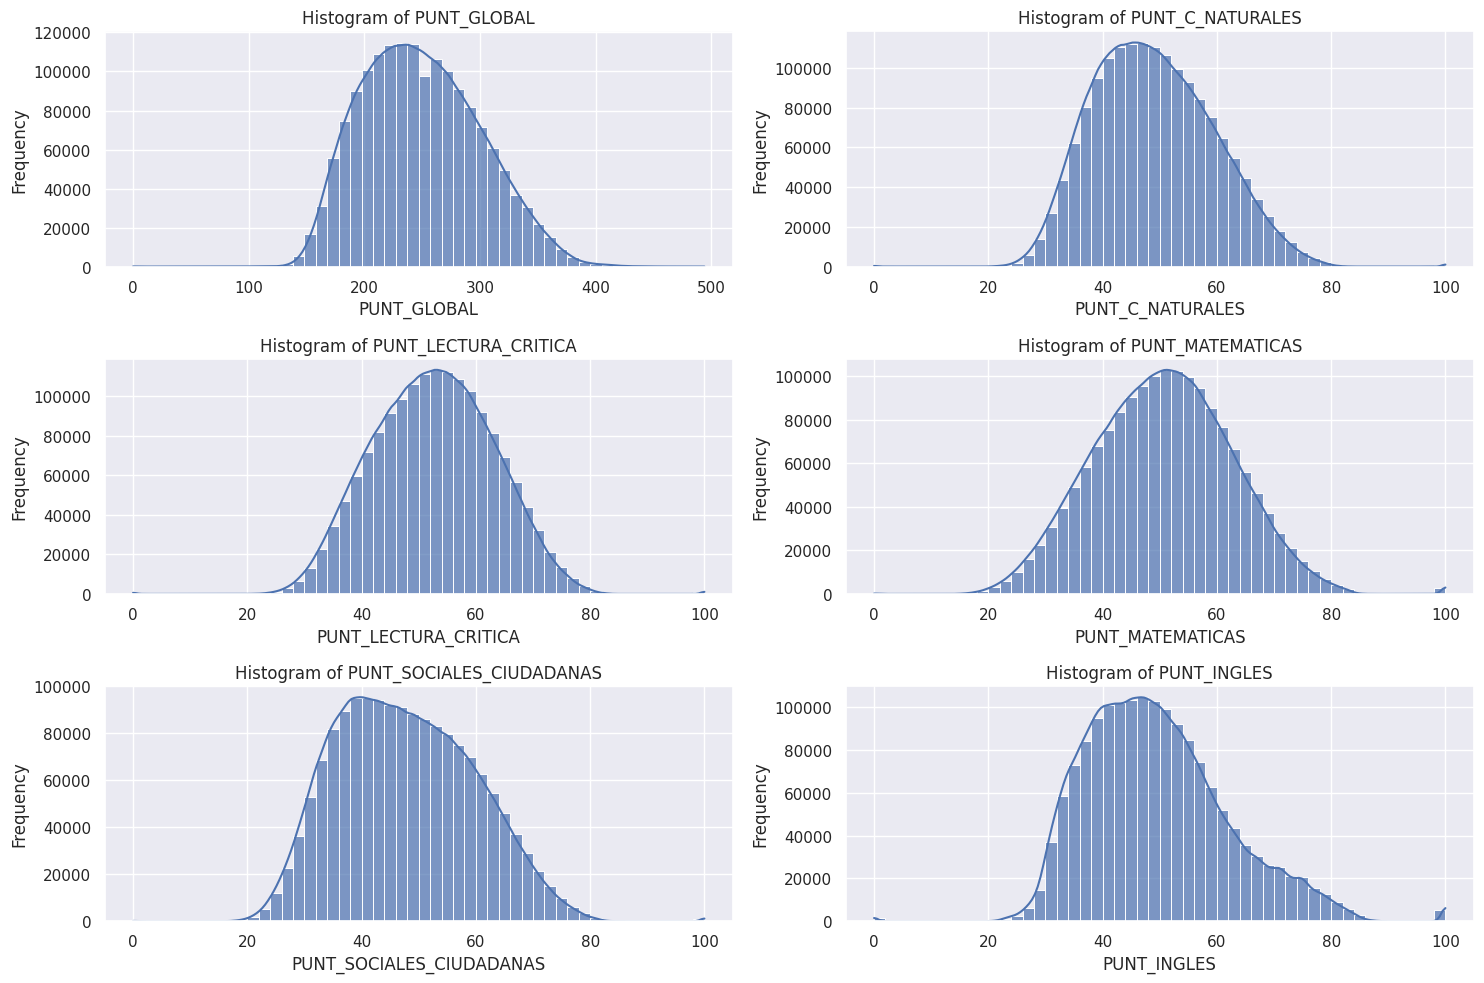

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_df is your PySpark DataFrame containing the specified variables

# Convert PySpark DataFrame to pandas DataFrame


# List of variables to create histograms for
variables = ["PUNT_GLOBAL", "PUNT_C_NATURALES", "PUNT_LECTURA_CRITICA", "PUNT_MATEMATICAS", "PUNT_SOCIALES_CIUDADANAS", "PUNT_INGLES"]

# Calculate number of rows and columns for subplots
num_plots = len(variables)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Create histograms
for i, var in enumerate(variables):
    sns.histplot(pDF[var], kde=True, alpha=0.7,bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Axes: xlabel='FAMI_EDUCACIONPADRE', ylabel='count'>

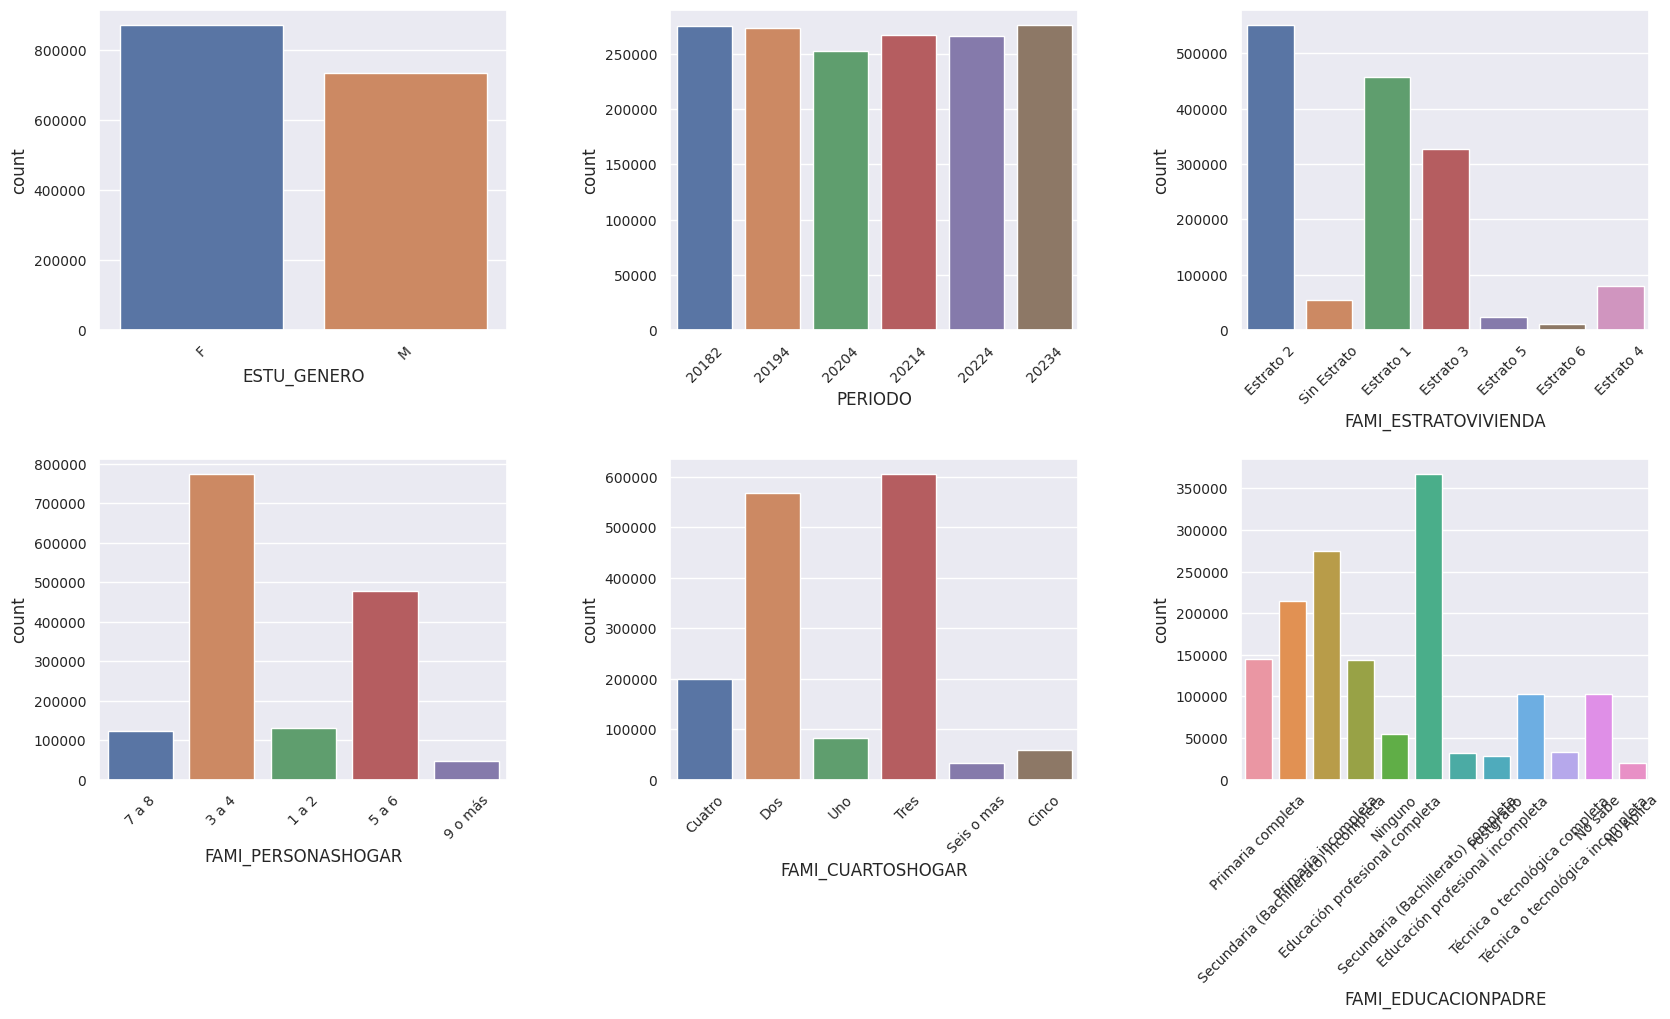

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.set_theme()

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
              

sns.countplot(data=pDF, x='ESTU_GENERO', ax=axes[0,0])
sns.countplot(data=pDF, x='PERIODO', ax=axes[0,1])
sns.countplot(data=pDF, x='FAMI_ESTRATOVIVIENDA', ax=axes[0,2])
sns.countplot(data=pDF, x='FAMI_PERSONASHOGAR', ax=axes[1,0])
sns.countplot(data=pDF, x='FAMI_CUARTOSHOGAR', ax=axes[1,1])
sns.countplot(data=pDF, x='FAMI_EDUCACIONPADRE', ax=axes[1,2])


<Axes: xlabel='FAMI_TIENEHORNOMICROOGAS', ylabel='count'>

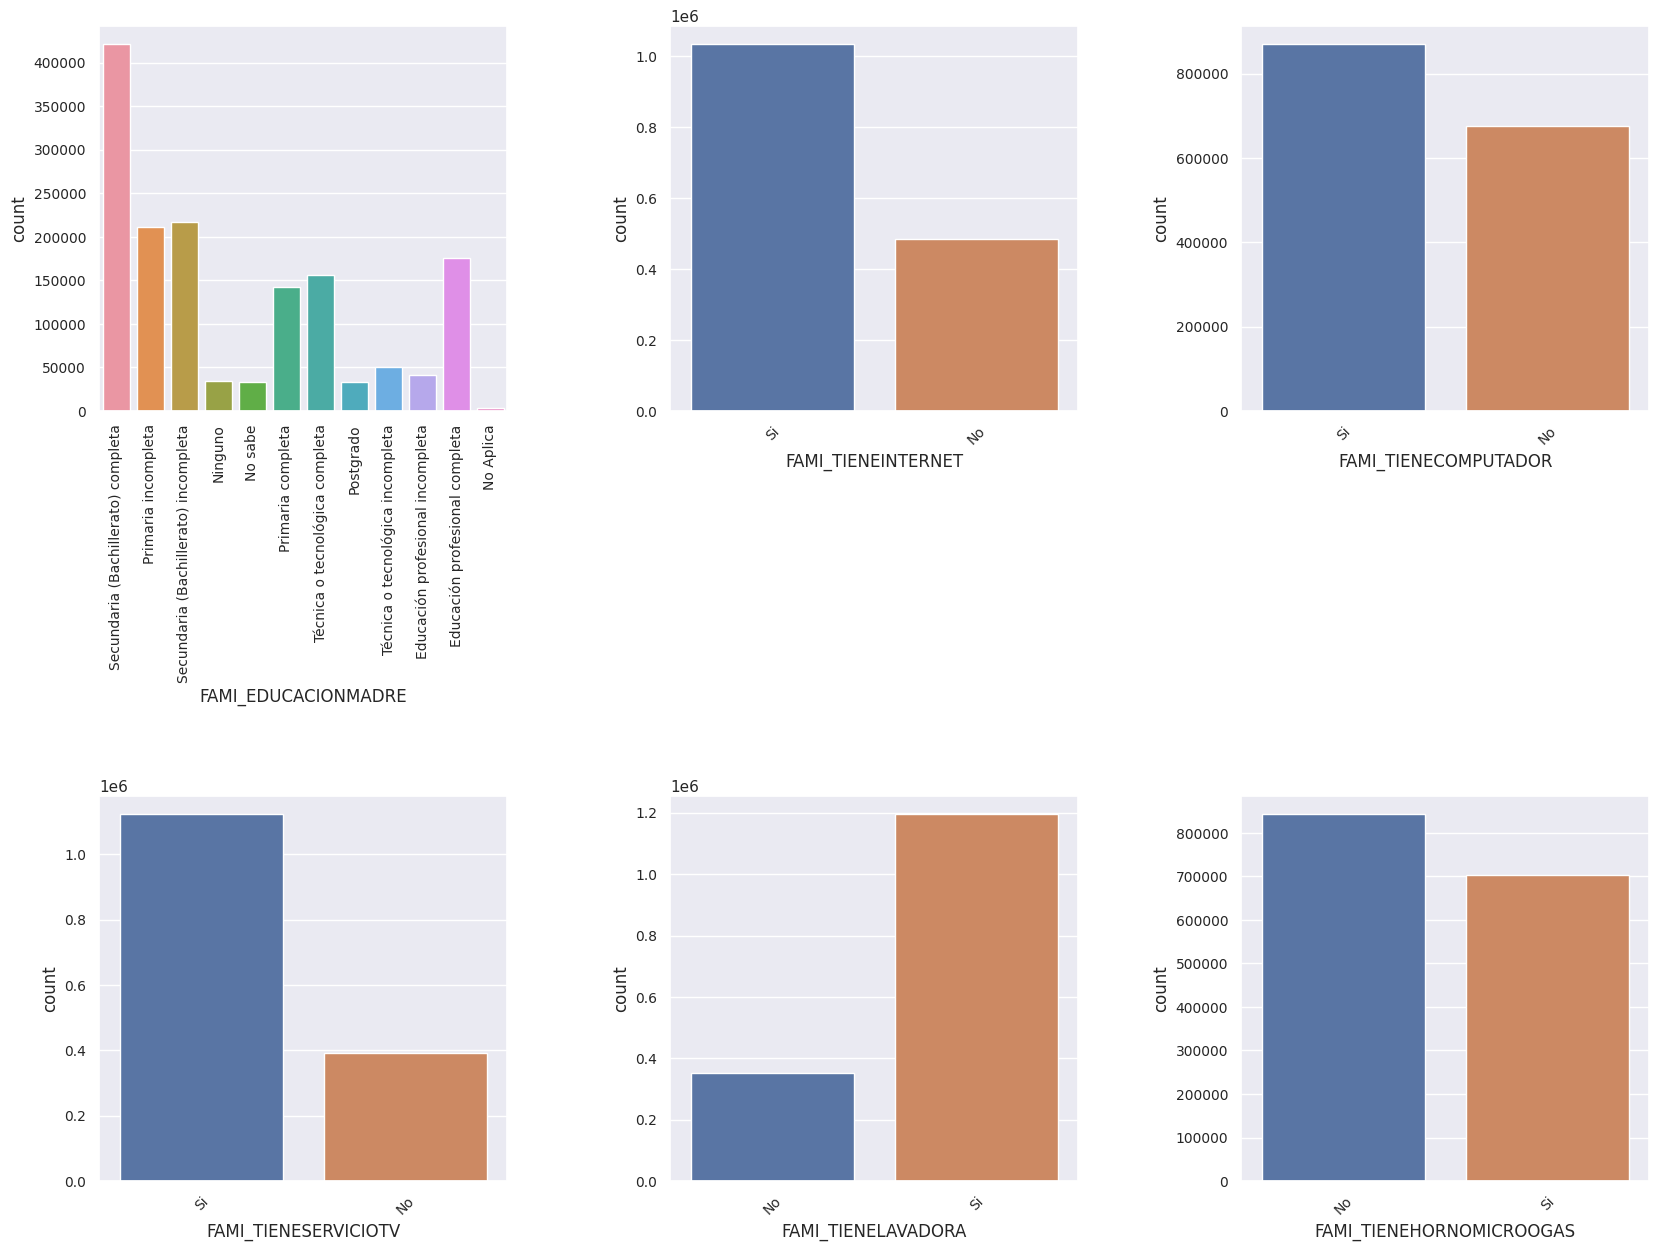

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(20,15))
plt.subplots_adjust(hspace=1, wspace=0.4)
sns.set_theme()
for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
              
sns.countplot(data=pDF, x='FAMI_EDUCACIONMADRE', ax=axes[0,0])
axes[0,0].tick_params(axis='x', labelrotation=90, labelsize=10)
sns.countplot(data=pDF, x='FAMI_TIENEINTERNET', ax=axes[0,1])
sns.countplot(data=pDF, x='FAMI_TIENECOMPUTADOR', ax=axes[0,2])
sns.countplot(data=pDF, x='FAMI_TIENESERVICIOTV', ax=axes[1,0])
sns.countplot(data=pDF, x='FAMI_TIENELAVADORA', ax=axes[1,1])
sns.countplot(data=pDF, x='FAMI_TIENEHORNOMICROOGAS', ax=axes[1,2])

<Axes: xlabel='COLE_CARACTER', ylabel='count'>

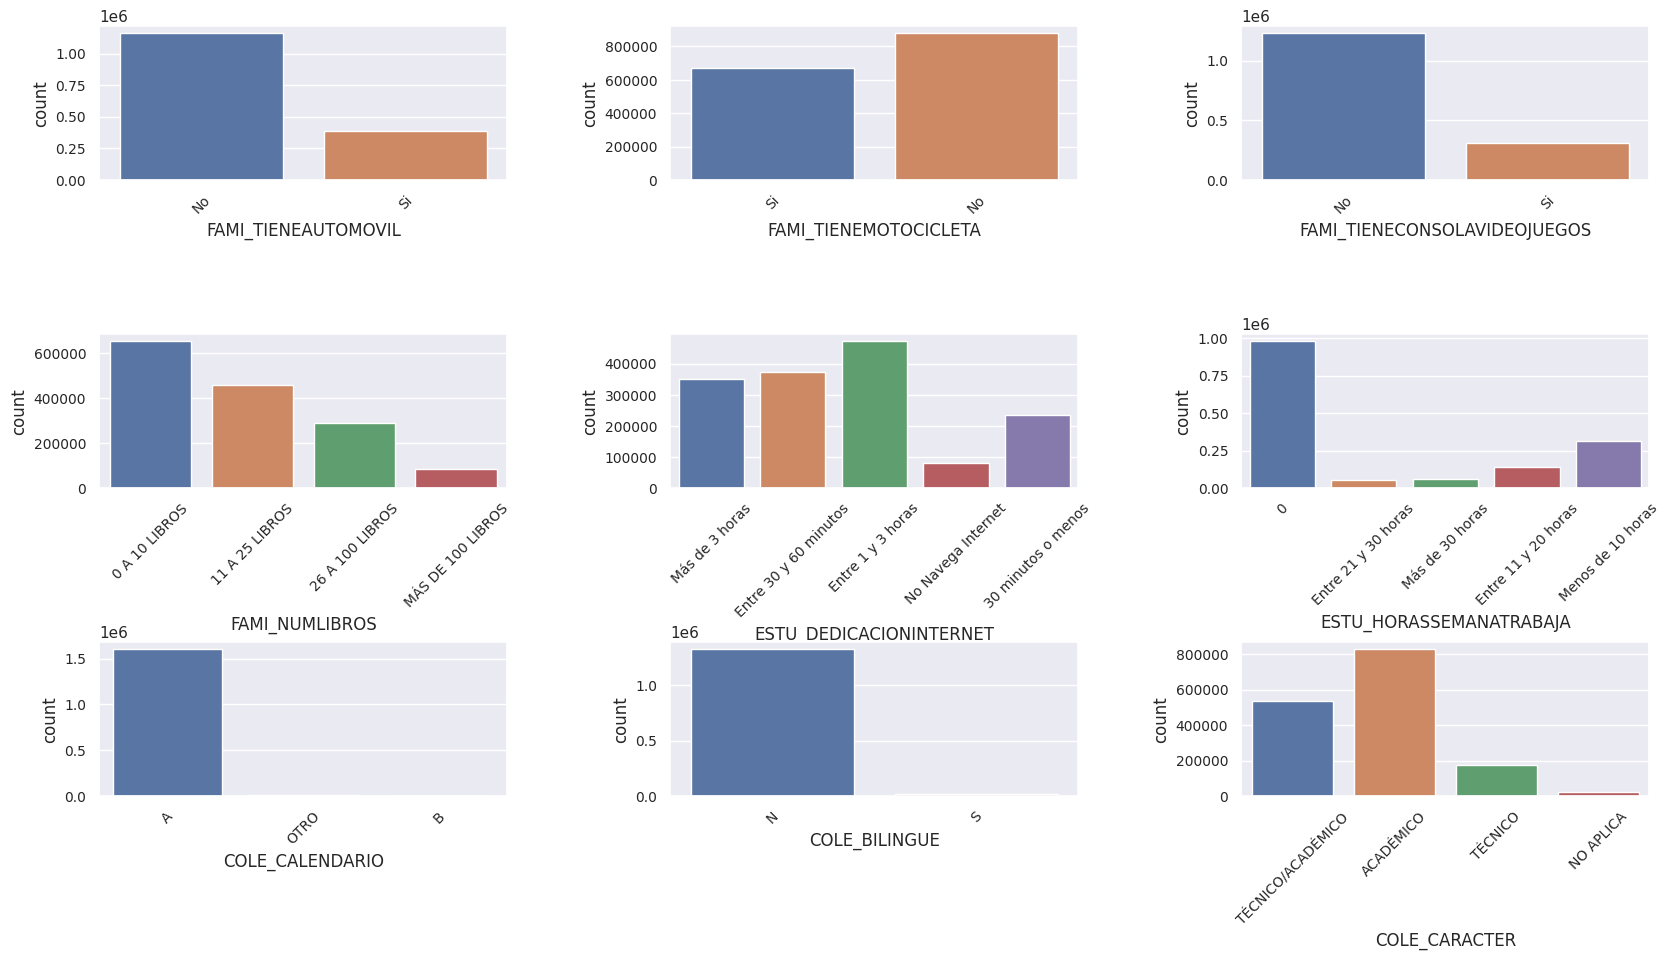

In [0]:
fig, axes = plt.subplots(3, 3, figsize=(20,10))
plt.subplots_adjust(hspace=1, wspace=0.4)
sns.set_theme()

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

sns.countplot(data=pDF, x='FAMI_TIENEAUTOMOVIL', ax=axes[0,0])
sns.countplot(data=pDF, x='FAMI_TIENEMOTOCICLETA', ax=axes[0,1])
sns.countplot(data=pDF, x='FAMI_TIENECONSOLAVIDEOJUEGOS', ax=axes[0,2])
sns.countplot(data=pDF, x='FAMI_NUMLIBROS', ax=axes[1,0])
sns.countplot(data=pDF, x='ESTU_DEDICACIONINTERNET', ax=axes[1,1])
sns.countplot(data=pDF, x='ESTU_HORASSEMANATRABAJA', ax=axes[1,2])
sns.countplot(data=pDF, x='COLE_CALENDARIO', ax=axes[2,0])
sns.countplot(data=pDF, x='COLE_BILINGUE', ax=axes[2,1])
sns.countplot(data=pDF, x='COLE_CARACTER', ax=axes[2,2])

In [0]:
final_df.groupBy("FAMI_ESTRATOVIVIENDA").count().show()
final_df.groupBy("FAMI_PERSONASHOGAR").count().show()
final_df.groupBy("FAMI_EDUCACIONPADRE").count().show()
final_df.groupBy("FAMI_EDUCACIONMADRE").count().show()
final_df.groupBy("ESTU_DEDICACIONINTERNET").count().show()
final_df.groupBy("ESTU_HORASSEMANATRABAJA").count().show()

+--------------------+------+
|FAMI_ESTRATOVIVIENDA| count|
+--------------------+------+
|           Estrato 3|327959|
|                NULL|103238|
|           Estrato 2|550991|
|           Estrato 6| 11100|
|           Estrato 4| 80669|
|         Sin Estrato| 54229|
|           Estrato 1|456535|
|           Estrato 5| 24522|
+--------------------+------+

+------------------+------+
|FAMI_PERSONASHOGAR| count|
+------------------+------+
|              NULL| 58746|
|             7 a 8|121821|
|             3 a 4|773819|
|             1 a 2|129692|
|           9 o más| 46794|
|             5 a 6|478371|
+------------------+------+

+--------------------+------+
| FAMI_EDUCACIONPADRE| count|
+--------------------+------+
|           Postgrado| 27726|
|             Ninguno| 54969|
|                NULL| 90048|
|             No sabe|102556|
|           No Aplica| 20290|
|   Primaria completa|145205|
|Secundaria (Bachi...|367320|
|Educación profesi...|143750|
|Secundaria (Bachi...|214949

In [0]:
sns.swarmplot(data=pDF, x="PUNT_GLOBAL", y="FAMI_ESTRATOVIVIENDA", hue="FAMI_ESTRATOVIVIENDA")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:103)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:103)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

<Axes: xlabel='FAMI_ESTRATOVIVIENDA', ylabel='PUNT_GLOBAL'>

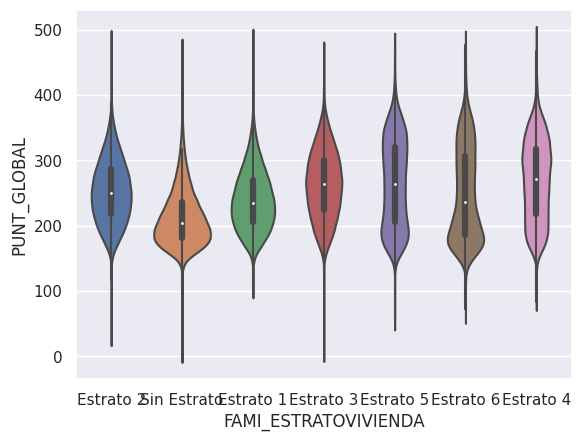

In [0]:
sns.violinplot(data=pDF, x='FAMI_ESTRATOVIVIENDA', y='PUNT_GLOBAL')

<Axes: xlabel='PUNT_GLOBAL', ylabel='Density'>

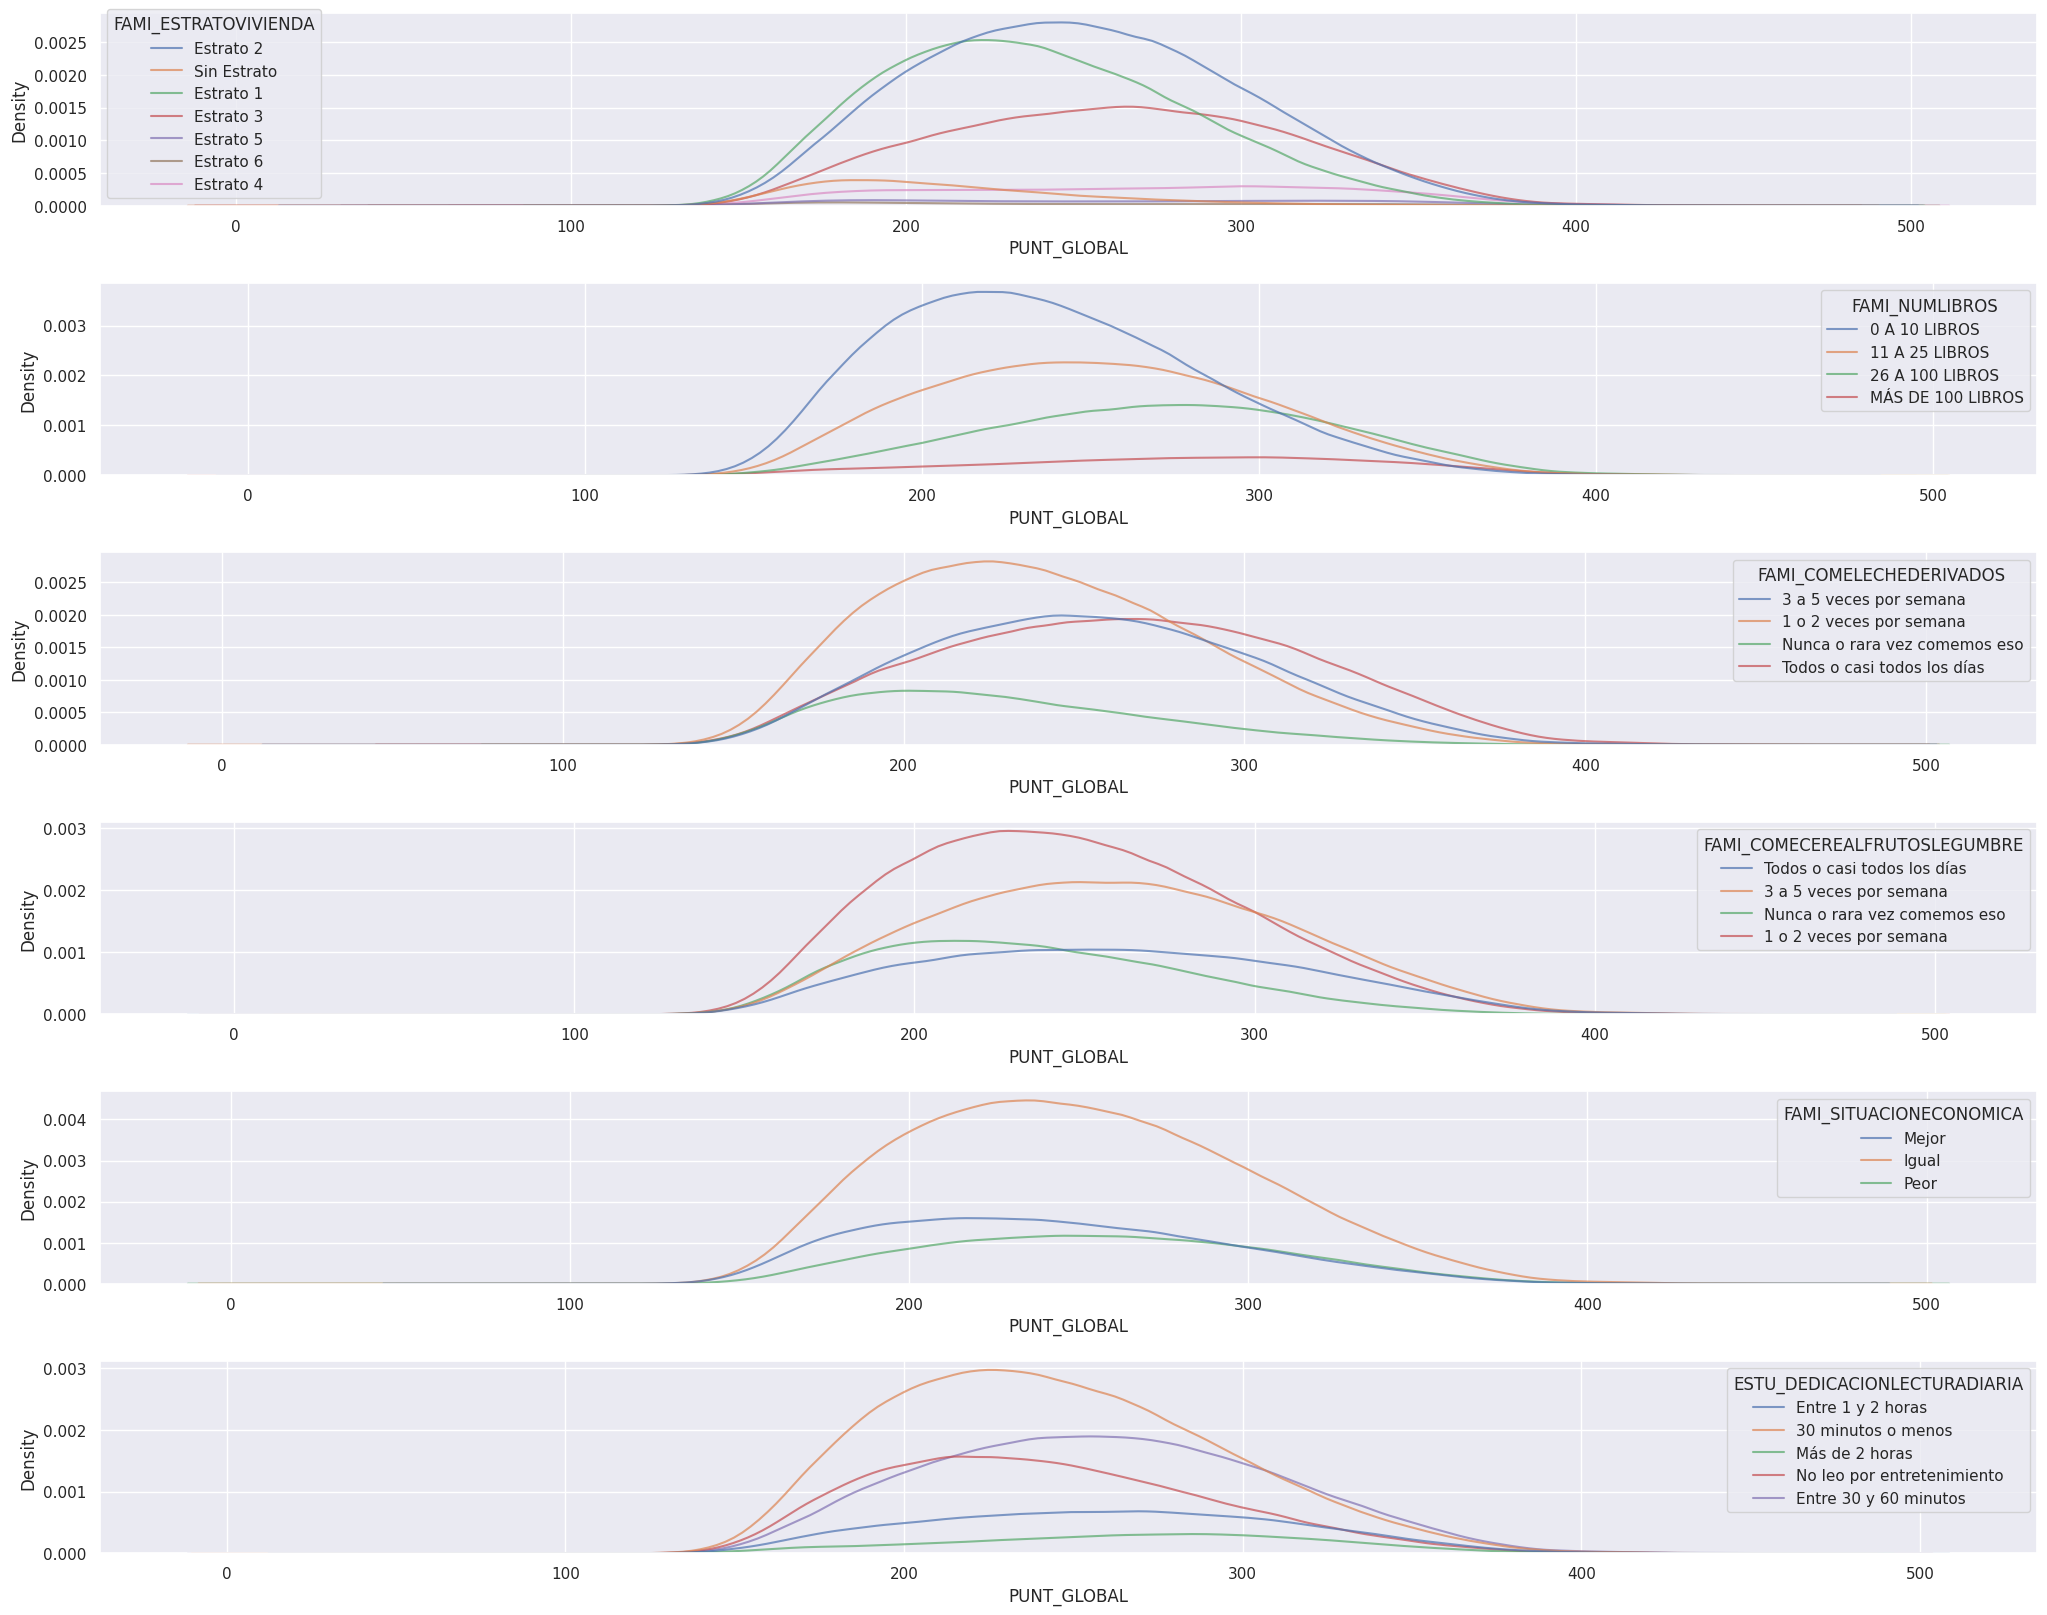

In [0]:
fig, axes = plt.subplots(6, 1, figsize=(25,20))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()

sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='FAMI_ESTRATOVIVIENDA', fill=False,alpha=0.7, ax=axes[0])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='FAMI_NUMLIBROS', fill=False,alpha=0.7, ax=axes[1])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='FAMI_COMELECHEDERIVADOS', fill=False,alpha=0.7, ax=axes[2])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='FAMI_COMECEREALFRUTOSLEGUMBRE', fill=False,alpha=0.7, ax=axes[3])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='FAMI_SITUACIONECONOMICA', fill=False,alpha=0.7, ax=axes[4])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='ESTU_DEDICACIONLECTURADIARIA', fill=False,alpha=0.7, ax=axes[5])

<Axes: xlabel='FAMI_ESTRATOVIVIENDA', ylabel='count'>

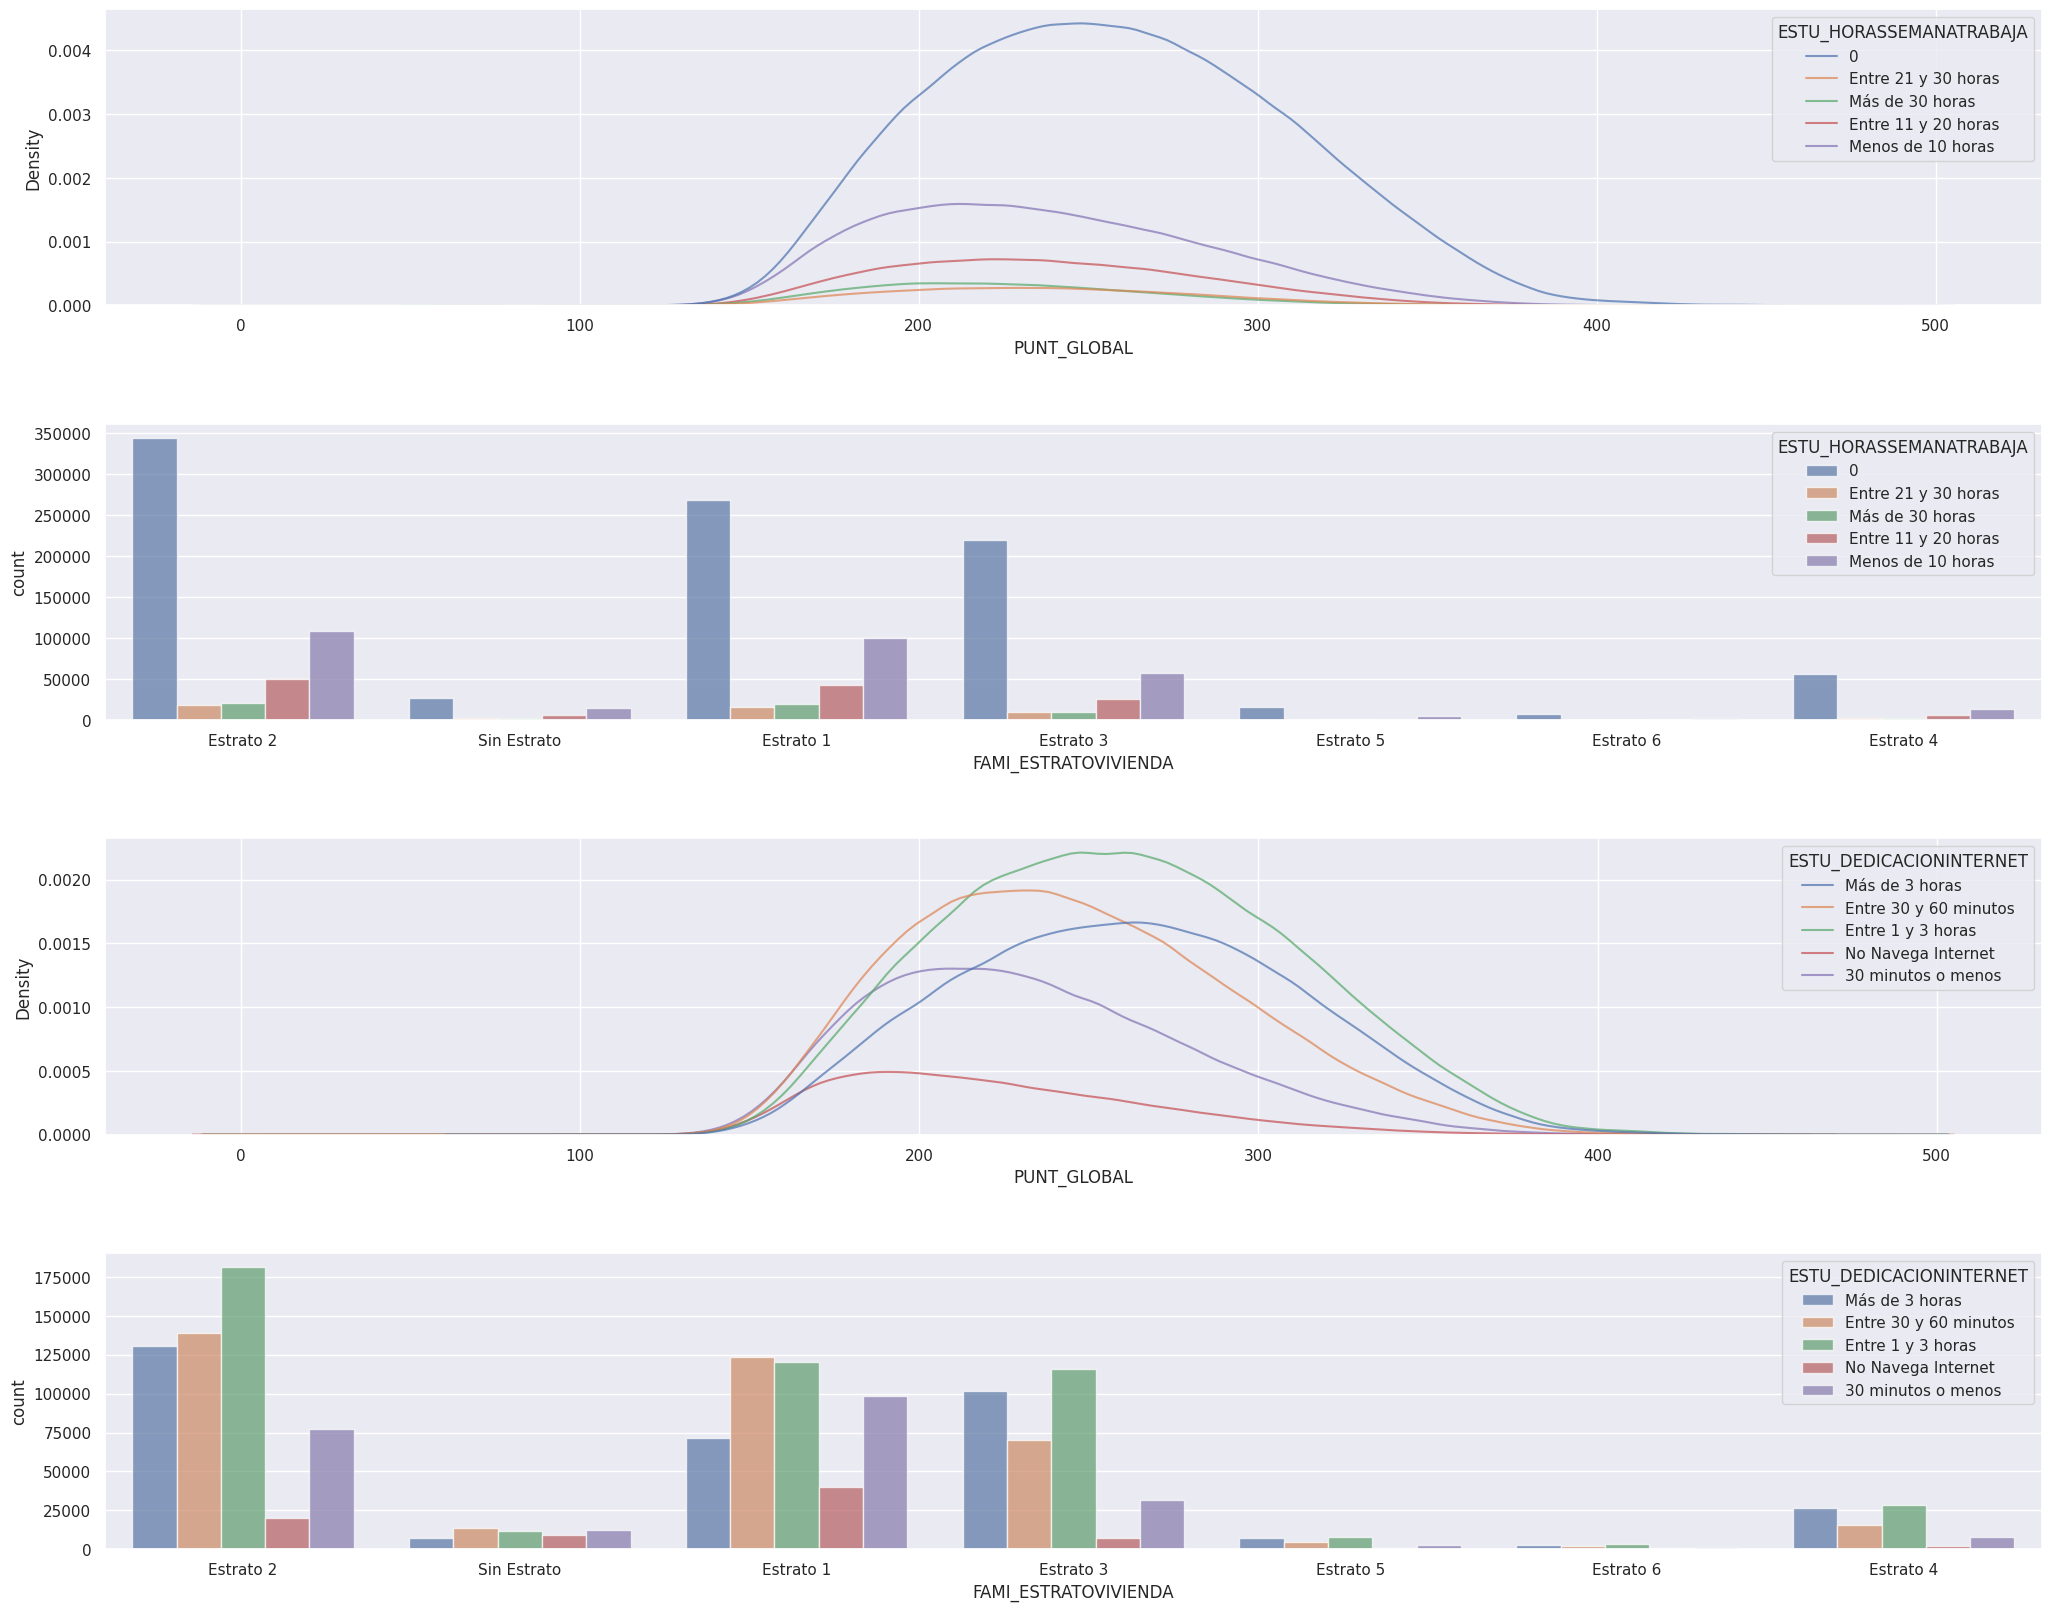

In [0]:
fig, axes = plt.subplots(4, 1, figsize=(25,20))
plt.subplots_adjust(hspace=0.4)
sns.set_theme()

sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='ESTU_HORASSEMANATRABAJA', fill=False,alpha=0.7, ax=axes[0])
sns.countplot(x="FAMI_ESTRATOVIVIENDA", hue="ESTU_HORASSEMANATRABAJA", data=pDF,alpha=0.7, ax=axes[1])
sns.kdeplot(data=pDF, x='PUNT_GLOBAL', hue='ESTU_DEDICACIONINTERNET', fill=False,alpha=0.7, ax=axes[2])
sns.countplot(x="FAMI_ESTRATOVIVIENDA", hue="ESTU_DEDICACIONINTERNET", data=pDF,alpha=0.7, ax=axes[3])


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/root/.ipykernel/18191/command-3924967444279005-1972476889:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


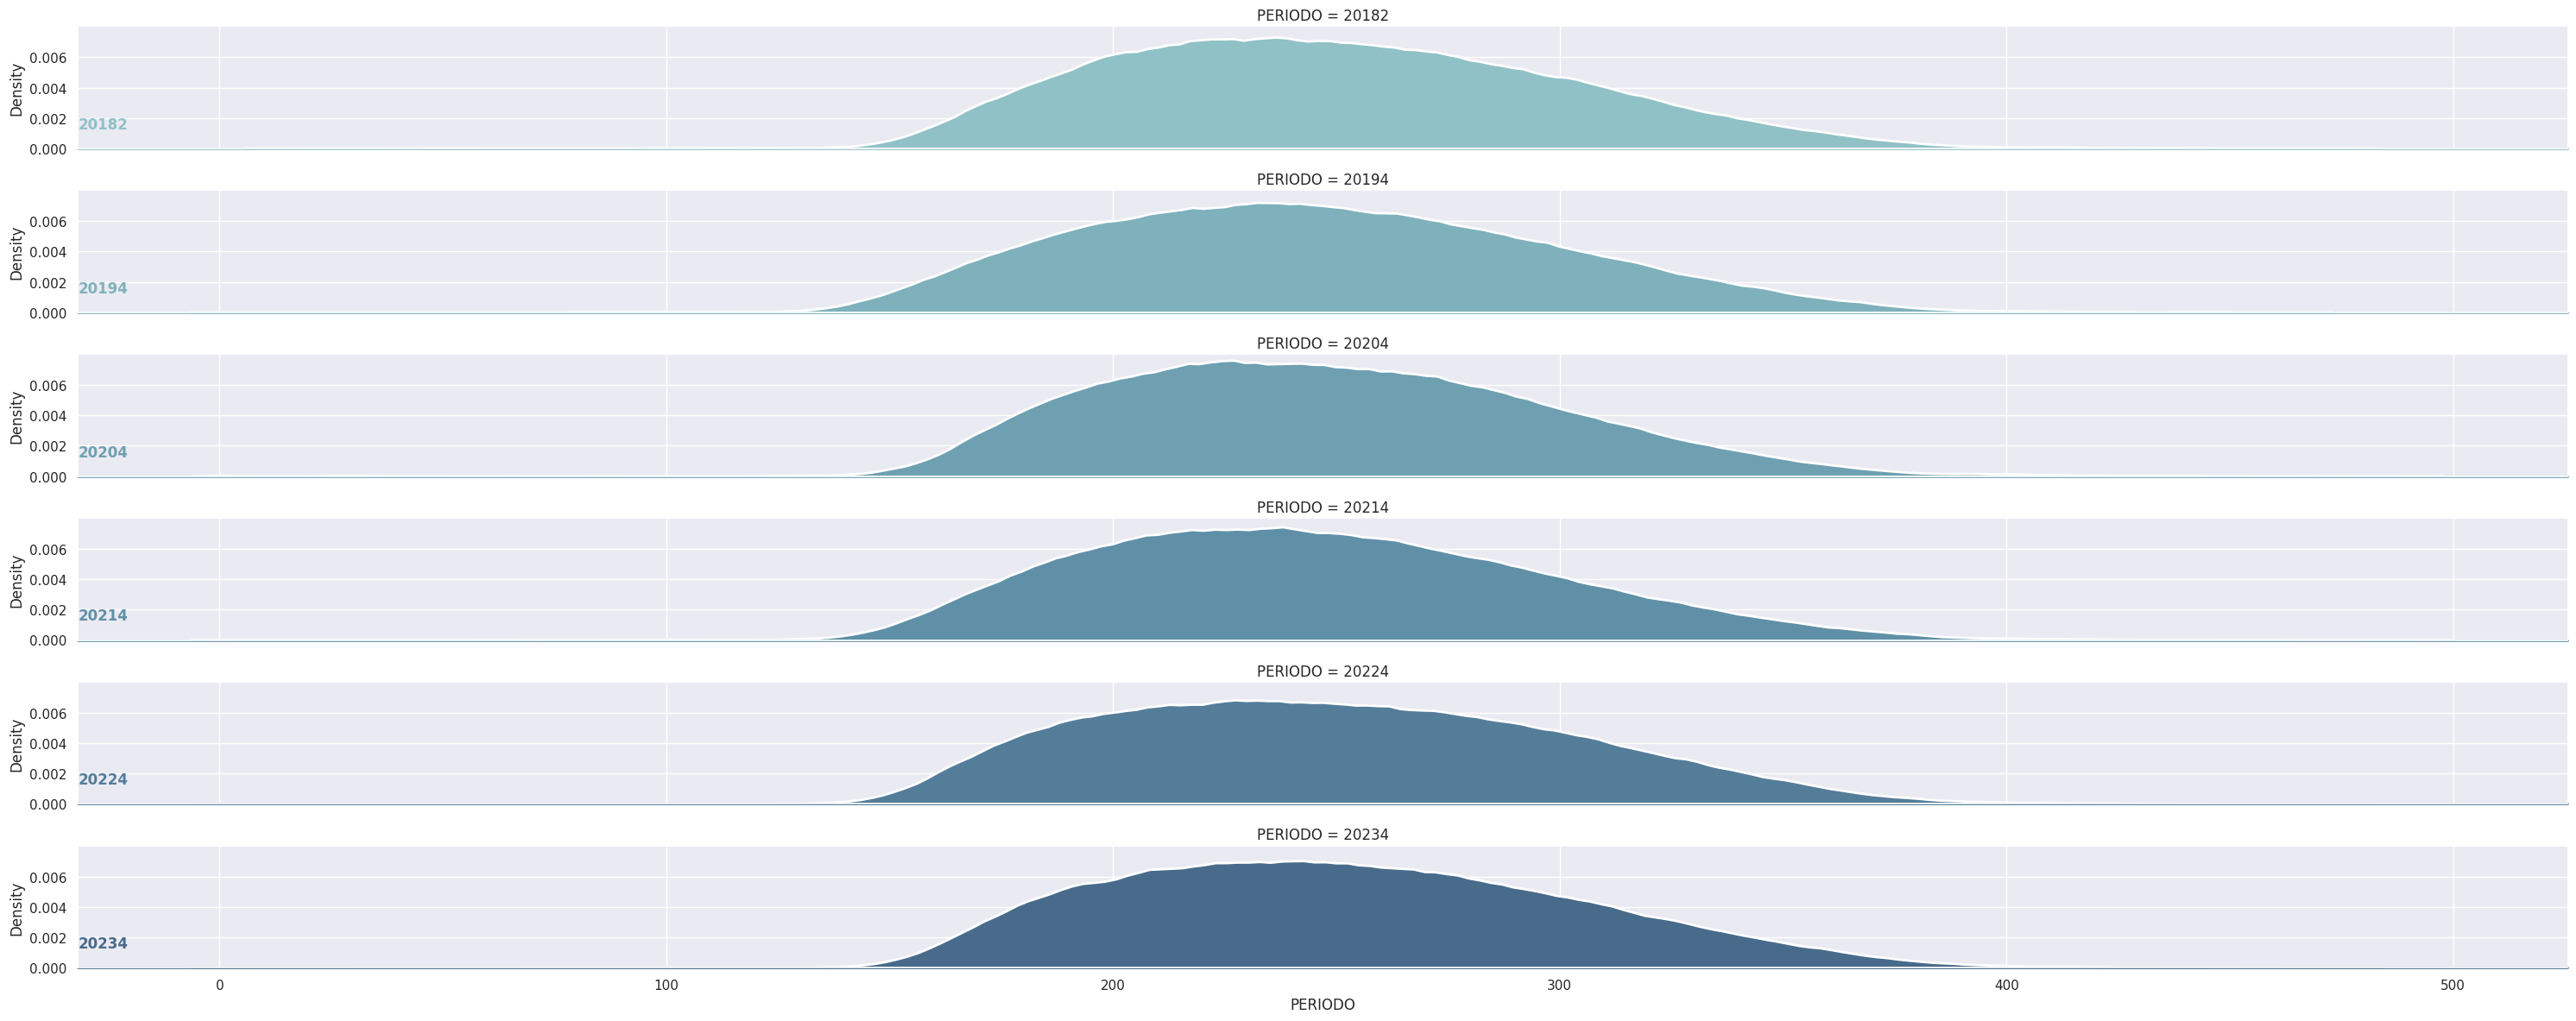

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# Create FacetGrid with increased height
g = sns.FacetGrid(pDF, row="PERIODO", hue="PERIODO", aspect=15, height=2, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "PUNT_GLOBAL", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "PUNT_GLOBAL", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Set reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a function to label the plot
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "PERIODO")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

plt.tight_layout()
# Show the plot
plt.show()


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/root/.ipykernel/18191/command-3924967444279007-971713642:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


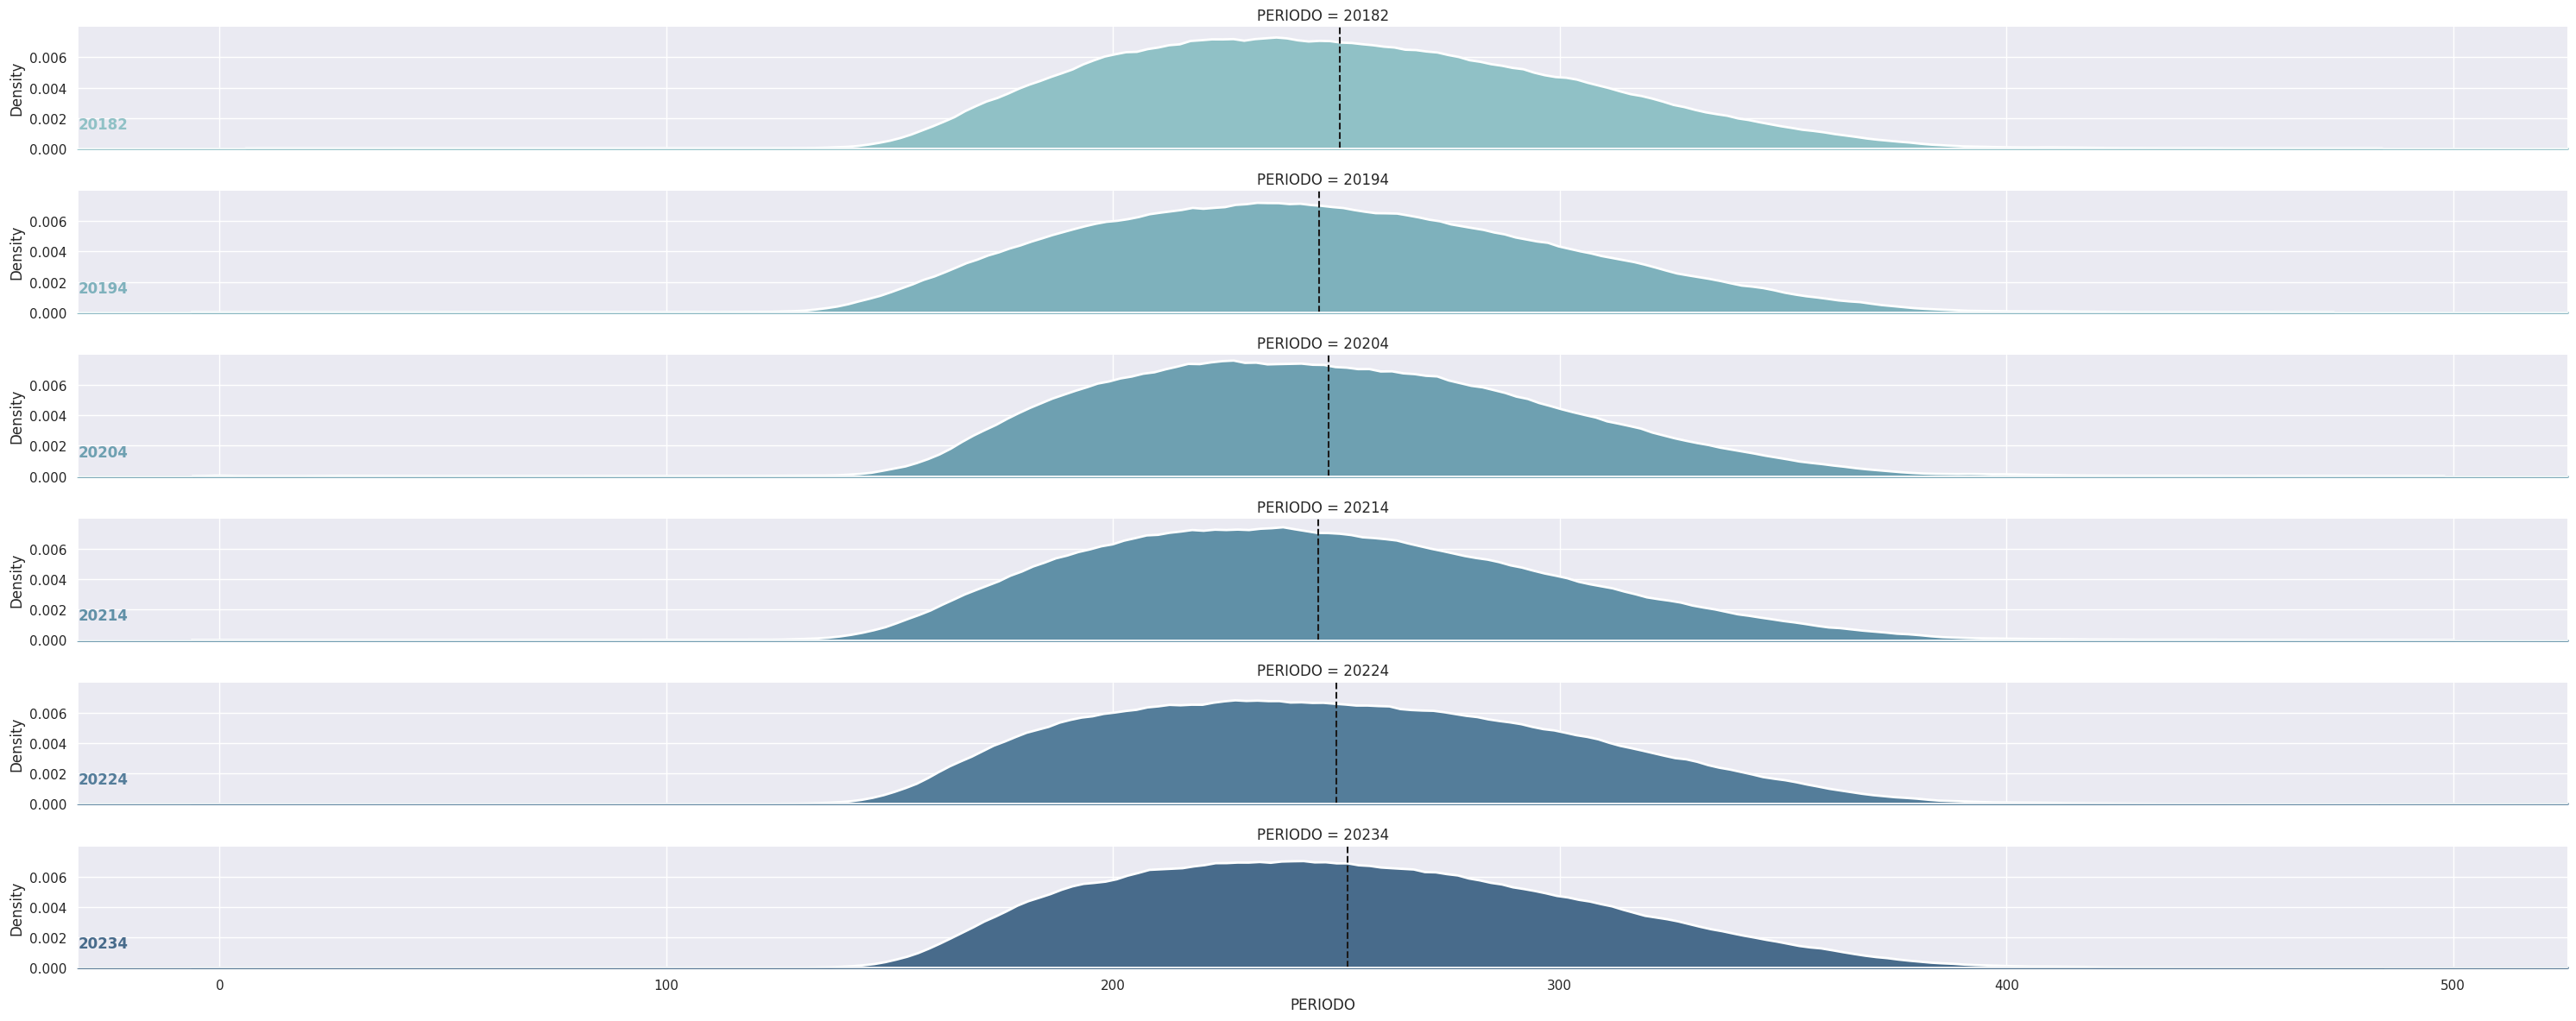

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# Create FacetGrid with increased height
g = sns.FacetGrid(pDF, row="PERIODO", hue="PERIODO", aspect=15, height=2, palette=pal)

# Draw the densities
g.map(sns.kdeplot, "PUNT_GLOBAL", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "PUNT_GLOBAL", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Set reference line
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Calculate and plot mean
def add_mean_line(x, **kwargs):
    mean_val = x.mean()
    plt.axvline(mean_val, color='k', linestyle='--')

g.map(add_mean_line, "PUNT_GLOBAL")

# Define and use a function to label the plot
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "PERIODO")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

plt.tight_layout()
# Show the plot
plt.show()


In [0]:
final_df.groupBy("PERIODO").agg(mean("PUNT_GLOBAL").alias("Mean_Puntaje_global")).show()

+-------+-------------------+
|PERIODO|Mean_Puntaje_global|
+-------+-------------------+
|  20182| 250.73193239088113|
|  20194| 246.14663581424003|
|  20204| 248.26212265272164|
|  20214|   245.999146514936|
|  20224| 250.08718748239008|
|  20234| 252.50555279777672|
+-------+-------------------+



# Machine learning

In [0]:
final_df.columns

['ESTU_TIPODOCUMENTO',
 'ESTU_NACIONALIDAD',
 'ESTU_GENERO',
 'ESTU_FECHANACIMIENTO',
 'PERIODO',
 'ESTU_CONSECUTIVO',
 'ESTU_ESTUDIANTE',
 'ESTU_PAIS_RESIDE',
 'ESTU_DEPTO_RESIDE',
 'ESTU_COD_RESIDE_DEPTO',
 'ESTU_MCPIO_RESIDE',
 'ESTU_COD_RESIDE_MCPIO',
 'FAMI_ESTRATOVIVIENDA',
 'FAMI_PERSONASHOGAR',
 'FAMI_CUARTOSHOGAR',
 'FAMI_EDUCACIONPADRE',
 'FAMI_EDUCACIONMADRE',
 'FAMI_TRABAJOLABORPADRE',
 'FAMI_TRABAJOLABORMADRE',
 'FAMI_TIENEINTERNET',
 'FAMI_TIENESERVICIOTV',
 'FAMI_TIENECOMPUTADOR',
 'FAMI_TIENELAVADORA',
 'FAMI_TIENEHORNOMICROOGAS',
 'FAMI_TIENEAUTOMOVIL',
 'FAMI_TIENEMOTOCICLETA',
 'FAMI_TIENECONSOLAVIDEOJUEGOS',
 'FAMI_NUMLIBROS',
 'FAMI_COMELECHEDERIVADOS',
 'FAMI_COMECARNEPESCADOHUEVO',
 'FAMI_COMECEREALFRUTOSLEGUMBRE',
 'FAMI_SITUACIONECONOMICA',
 'ESTU_DEDICACIONLECTURADIARIA',
 'ESTU_DEDICACIONINTERNET',
 'ESTU_HORASSEMANATRABAJA',
 'ESTU_TIPOREMUNERACION',
 'COLE_CODIGO_ICFES',
 'COLE_COD_DANE_ESTABLECIMIENTO',
 'COLE_NOMBRE_ESTABLECIMIENTO',
 'COLE_GENERO',
 'COL

In [0]:
feature_columns = ['FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_CUARTOSHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','FAMI_TRABAJOLABORPADRE','FAMI_TRABAJOLABORMADRE','FAMI_TIENEINTERNET','FAMI_TIENESERVICIOTV','FAMI_TIENECOMPUTADOR',
'FAMI_TIENELAVADORA','FAMI_TIENEAUTOMOVIL','FAMI_TIENEMOTOCICLETA','FAMI_TIENECONSOLAVIDEOJUEGOS','FAMI_NUMLIBROS','FAMI_COMELECHEDERIVADOS','FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE','FAMI_SITUACIONECONOMICA','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','ESTU_HORASSEMANATRABAJA',"PUNT_GLOBAL"]


In [0]:
used_variablesdf = final_df.select(feature_columns)


In [0]:
used_variablesdf.select([((count(when(isnan(c) | col(c).isNull(), c))) ).alias(c) for c in used_variablesdf.columns]).show()

+--------------------+------------------+-----------------+-------------------+-------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+-------------------+---------------------+----------------------------+--------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+-----------+
|FAMI_ESTRATOVIVIENDA|FAMI_PERSONASHOGAR|FAMI_CUARTOSHOGAR|FAMI_EDUCACIONPADRE|FAMI_EDUCACIONMADRE|FAMI_TRABAJOLABORPADRE|FAMI_TRABAJOLABORMADRE|FAMI_TIENEINTERNET|FAMI_TIENESERVICIOTV|FAMI_TIENECOMPUTADOR|FAMI_TIENELAVADORA|FAMI_TIENEAUTOMOVIL|FAMI_TIENEMOTOCICLETA|FAMI_TIENECONSOLAVIDEOJUEGOS|FAMI_NUMLIBROS|FAMI_COMELECHEDERIVADOS|FAMI_COMECARNEPESCADOHUEVO|FAMI_COMECEREALFRUTOSLEGUMBRE|FAMI_SITUACIONECONOMICA|ESTU_DEDICACIONLECTURADIARIA|ESTU_DEDICACIONINTERNET|ESTU_HORASSEMANATRABAJA|P

In [0]:
used_variablesdf = used_variablesdf.dropna()

In [0]:
used_variablesdf.show()

+--------------------+------------------+-----------------+--------------------+--------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+-------------------+---------------------+----------------------------+---------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+-----------+
|FAMI_ESTRATOVIVIENDA|FAMI_PERSONASHOGAR|FAMI_CUARTOSHOGAR| FAMI_EDUCACIONPADRE| FAMI_EDUCACIONMADRE|FAMI_TRABAJOLABORPADRE|FAMI_TRABAJOLABORMADRE|FAMI_TIENEINTERNET|FAMI_TIENESERVICIOTV|FAMI_TIENECOMPUTADOR|FAMI_TIENELAVADORA|FAMI_TIENEAUTOMOVIL|FAMI_TIENEMOTOCICLETA|FAMI_TIENECONSOLAVIDEOJUEGOS| FAMI_NUMLIBROS|FAMI_COMELECHEDERIVADOS|FAMI_COMECARNEPESCADOHUEVO|FAMI_COMECEREALFRUTOSLEGUMBRE|FAMI_SITUACIONECONOMICA|ESTU_DEDICACIONLECTURADIARIA|ESTU_DEDICACIONINTERNET|ESTU_HORASSEMANATRA

In [0]:
used_variablesdf.columns

['FAMI_ESTRATOVIVIENDA',
 'FAMI_PERSONASHOGAR',
 'FAMI_CUARTOSHOGAR',
 'FAMI_EDUCACIONPADRE',
 'FAMI_EDUCACIONMADRE',
 'FAMI_TRABAJOLABORPADRE',
 'FAMI_TRABAJOLABORMADRE',
 'FAMI_TIENEINTERNET',
 'FAMI_TIENESERVICIOTV',
 'FAMI_TIENECOMPUTADOR',
 'FAMI_TIENELAVADORA',
 'FAMI_TIENEAUTOMOVIL',
 'FAMI_TIENEMOTOCICLETA',
 'FAMI_TIENECONSOLAVIDEOJUEGOS',
 'FAMI_NUMLIBROS',
 'FAMI_COMELECHEDERIVADOS',
 'FAMI_COMECARNEPESCADOHUEVO',
 'FAMI_COMECEREALFRUTOSLEGUMBRE',
 'FAMI_SITUACIONECONOMICA',
 'ESTU_DEDICACIONLECTURADIARIA',
 'ESTU_DEDICACIONINTERNET',
 'ESTU_HORASSEMANATRABAJA',
 'PUNT_GLOBAL']

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator


data = used_variablesdf
# Define the features columns
feature_cols = ['FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR',
                'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE',
                'FAMI_TRABAJOLABORMADRE', 'FAMI_TIENEINTERNET', 'FAMI_TIENESERVICIOTV',
                'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
                'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS',
                'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO',
                'FAMI_COMECEREALFRUTOSLEGUMBRE', 'FAMI_SITUACIONECONOMICA',
                'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET',
                'ESTU_HORASSEMANATRABAJA']

# Assuming 'data' is your DataFrame
string_cols = ['FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR', 'FAMI_CUARTOSHOGAR',
               'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_TRABAJOLABORPADRE',
               'FAMI_TRABAJOLABORMADRE', 'FAMI_TIENEINTERNET', 'FAMI_TIENESERVICIOTV',
               'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
               'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_NUMLIBROS',
               'FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO',
               'FAMI_COMECEREALFRUTOSLEGUMBRE', 'FAMI_SITUACIONECONOMICA',
               'ESTU_DEDICACIONLECTURADIARIA', 'ESTU_DEDICACIONINTERNET',
               'ESTU_HORASSEMANATRABAJA']

# Convert string columns to numerical representations
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in string_cols]
pipeline = Pipeline(stages=indexers)
indexed_data = pipeline.fit(data).transform(data)

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split the data into train and test sets (you might need to adjust the ratios)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Define the regression model
rf = RandomForestRegressor(featuresCol="features", labelCol="PUNT_GLOBAL")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="PUNT_GLOBAL", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Extract feature importance
importances = model.stages[-1].featureImportances
feature_importance_df = spark.createDataFrame(zip(feature_cols, importances), ["feature", "importance"])
feature_importance_df.sort("importance", ascending=False).show()




com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:103)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:103)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


# Split data into train and test sets
(train_data, test_data) = assembled_features_df.randomSplit([0.8, 0.2], seed=1234)

# Train a RandomForestClassifier model
rf = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=100)
model = rf.fit(train_data)

# Get feature importance scores
feature_importance = model.featureImportances

# Print feature importance scores
for i, feature in enumerate(string_cols):
    print("{}: {}".format(feature, feature_importance[i]))

# You can also visualize feature importance scores for better analysis

# Make predictions


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3924967444279010>, line 10
      7 (train_data, test_data) = assembled_features_df.randomSplit([0.8, 0.2], seed=1234)
      9 # Train a RandomForestClassifier model
---> 10 rf = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=100)
     11 model = rf.fit(train_data)
     13 # Get feature importance scores

NameError: name 'label_column' is not defined

In [0]:
plt.figure(figsize=(10, 6))
plt.barh(string_cols, feature_importance, color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
plt.show()

##Unificación de los datasets desde el 2018 hasta el 2023 (segundos periodos 'XXXX-2' )

In [0]:
# Unificar los DataFrames
DF_Resultados_Unificados_Segundos_Periodos = pd.join([DF_Resultados_2018_2, DF_Resultados_2019_2, DF_Resultados_2020_2, DF_Resultados_2021_2, DF_Resultados_2022_2, DF_Resultados_2023_2])


# Se cargan los datos a un dataframe de PySpark y visualizarlos con Spark directamente:
DFS_Ventas_Unificadas = sql_sc.createDataFrame(DF_Resultados_Unificados_Segundos_Periodos)
DFS_Ventas_Unificadas.show(11)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:412: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Expected bytes, got a 'float' object
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


+------------------+-----------------+-----------+--------------------+-------+----------------+---------------+----------------+---------------+--------------------+------------------+-----------------+---------------------+-------------------+---------------------+--------------------+------------------+-----------------+--------------------+--------------------+----------------------+----------------------+------------------+--------------------+--------------------+------------------+------------------------+-------------------+---------------------+----------------------------+--------------+-----------------------+--------------------------+-----------------------------+-----------------------+----------------------------+-----------------------+-----------------------+---------------------+-----------------+-----------------------------+---------------------------+-----------+---------------+---------------+-------------+-----------------+------------------+--------------------+

In [0]:
print("La cantidad de registros en el Data Frame de Spark es: " + str(DFS_Ventas_Unificadas.count()))

La cantidad de registros en el Data Frame de Spark es: 3217938


In [0]:
paths = ["https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pre-Pandemia/2018/2018-1/SB11_20181.TXT",
         "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2020/2020-1/SB11_20201.txt",
         "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Pandemia/2021/2021-1/SB11_20211.txt",
         "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2022/2022-1/SB11_20221.TXT",
         "https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Datos/Post-Pandemia/2023/2023-1/SB11_20231.TXT"]
# falta poner el maldito año de 2019
spark_dfs = []
schemas = []

for csv_path in paths:
    pandas_df = pd.read_csv(csv_path, delimiter='¬', engine='python')
    spark_df = spark.createDataFrame(pandas_df)
    spark_dfs.append(spark_df)
    schemas.append(spark_df.schema)



# Display schema differences
for i in range(len(schemas) - 1):
    print(f"Difference between DataFrame {i + 1} and DataFrame {i + 2}:")
    diff_cols = set(schemas[i].fieldNames()) - set(schemas[i + 1].fieldNames())
    if diff_cols:
        print("Columns in DataFrame", i + 1, "not in DataFrame", i + 2, ":", diff_cols)
    else:
        print("No differences found.")

Difference between DataFrame 1 and DataFrame 2:
Columns in DataFrame 1 not in DataFrame 2 : {'ESTU_ETNIA', 'ESTU_PILOPAGA'}
Difference between DataFrame 2 and DataFrame 3:
Columns in DataFrame 2 not in DataFrame 3 : {'ESTU_NSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_INSE_INDIVIDUAL', 'ESTU_GENERACION-E'}
Difference between DataFrame 3 and DataFrame 4:
No differences found.
Difference between DataFrame 4 and DataFrame 5:
Columns in DataFrame 4 not in DataFrame 5 : {'ESTU_TIENEETNIA', 'ESTU_AGREGADO'}


In [0]:
pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
pandas_df.columns = [col.upper() for col in pandas_df.columns]
spark_df = spark.createDataFrame(pandas_df)
spark_dfs.append(spark_df)
schemas.append(spark_df.schema)


---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
# Display schema differences
set(schemas[0].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[0].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[0].fieldNames()) - set(schemas[3].fieldNames())
set(schemas[0].fieldNames()) - set(schemas[4].fieldNames())
set(schemas[0].fieldNames()) - set(schemas[5].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[1].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[5].fieldNames()) - set(schemas[0].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[0] = spark_dfs[0].drop('ESTU_ETNIA', 'ESTU_PILOPAGA', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[1].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[1].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[1].fieldNames()) - set(schemas[3].fieldNames())
set(schemas[1].fieldNames()) - set(schemas[4].fieldNames())
set(schemas[1].fieldNames()) - set(schemas[5].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[0].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[5].fieldNames()) - set(schemas[1].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[1] = spark_dfs[1].drop('ESTU_GENERACION-E', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[2].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[3].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[4].fieldNames())
set(schemas[2].fieldNames()) - set(schemas[5].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[0].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[1].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[5].fieldNames()) - set(schemas[2].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[2] = spark_dfs[2].drop('ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[3].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[4].fieldNames())
set(schemas[3].fieldNames()) - set(schemas[5].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[3] = spark_dfs[3].drop('ESTU_AGREGADO', 'ESTU_TIENEETNIA','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_GENERACIONE','ESTU_INSE_INDIVIDUAL','ESTU_NSE_ESTABLECIMIENTO','ESTU_NSE_INDIVIDUAL','ESTU_TIENEETNIA')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
set(schemas[4].fieldNames()) - set(schemas[0].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[1].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[2].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[3].fieldNames())
set(schemas[4].fieldNames()) - set(schemas[5].fieldNames())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[4] = spark_dfs[4].drop('ESTU_PRESENTACIONSABADO', 'SEED_CODIGOMEN', 'SEED_NOMBRE','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_PRESENTACIONSABADO','PERCENTIL_ESPECIAL_GLOBAL','SEED_CODIGOMEN','SEED_NOMBRE')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
spark_dfs[5] = spark_dfs[5].drop('ESTU_PRESENTACIONSABADO', 'SEED_CODIGOMEN', 'SEED_NOMBRE','PERCENTIL_ESPECIAL_GLOBAL','ESTU_INSE_INDIVIDUAL', 'ESTU_NSE_ESTABLECIMIENTO', 'ESTU_NSE_INDIVIDUAL','ESTU_PRESENTACIONSABADO','PERCENTIL_ESPECIAL_GLOBAL','SEED_CODIGOMEN','SEED_NOMBRE','ESTU_GENERACIONE', 'ESTU_TIENEETNIA')

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
schemas = []
for spark_df in spark_dfs:
    schemas.append(spark_df.schema)

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
print(len(spark_dfs[0].columns))
print(len(spark_dfs[1].columns))
print(len(spark_dfs[2].columns))
print(len(spark_dfs[3].columns))
print(len(spark_dfs[4].columns))
print(len(spark_dfs[5].columns))

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:


final_df = spark_dfs[0]
for df in spark_dfs[1:]:
  final_df = final_df.union(df)

final_df.show()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
final_df.count()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
from pyspark.sql.functions import col

substring_to_search = "CAOBOS"
result = final_df.filter(col("COLE_NOMBRE_SEDE").contains(substring_to_search))
result.select("FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE").toPandas()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
total_rows = final_df.count()
# Calcula el porcentaje de valores nulos para cada columna
final_df.select([((count(when(isnan(c) | col(c).isNull(), c)) / total_rows) * 100).alias(c) for c in final_df.columns]).show()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:

final_df.select([((count(when(isnan(c) | col(c).isNull(), c))) ).alias(c) for c in final_df.columns]).show()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
borrar = ["ESTU_DEPTO_RESIDE","ESTU_COD_RESIDE_DEPTO","ESTU_MCPIO_RESIDE","ESTU_COD_RESIDE_MCPIO","FAMI_PERSONASHOGAR","FAMI_CUARTOSHOGAR","FAMI_TRABAJOLABORPADRE","FAMI_TRABAJOLABORMADRE","FAMI_TRABAJOLABORMADRE","FAMI_TIENECOMPUTADOR","FAMI_TIENELAVADORA","FAMI_TIENEHORNOMICROOGAS","FAMI_TIENEAUTOMOVIL","FAMI_TIENEMOTOCICLETA","FAMI_TIENECONSOLAVIDEOJUEGOS","FAMI_SITUACIONECONOMICA","ESTU_HORASSEMANATRABAJA","ESTU_HORASSEMANATRABAJA","ESTU_TIPOREMUNERACION","PUNT_INGLES","PERCENTIL_INGLES","DESEMP_INGLES","DESEMP_INGLES","PERCENTIL_GLOBAL"]
final_df = final_df.dropna(subset=borrar)

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
for col_name in borrar:
    final_df = final_df.filter(col(col_name).isNotNull())

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
for borr in borrar:
  final_df = final_df.filter((final_df[borr] != 'NaN'))

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
final_df.select([((count(when(isnan(c) | col(c).isNull(), c))) ).alias(c) for c in final_df.columns]).show()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
final_df.count()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
final_df.printSchema()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
PUNT_GLOBAL PUNT_C_NATURALES  PUNT_LECTURA_CRITICA PUNT_MATEMATICAS PUNT_SOCIALES_CIUDADANAS PUNT_INGLES

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
pandas_df = final_df.toPandas()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming final_df is your PySpark DataFrame containing the specified variables

# Convert PySpark DataFrame to pandas DataFrame


# List of variables to create histograms for
variables = ["PUNT_GLOBAL", "PUNT_C_NATURALES", "PUNT_LECTURA_CRITICA", "PUNT_MATEMATICAS", "PUNT_SOCIALES_CIUDADANAS", "PUNT_INGLES"]

# Calculate number of rows and columns for subplots
num_plots = len(variables)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Create histograms
for i, var in enumerate(variables):
    sns.histplot(pandas_df[var], kde=True, alpha=0.7,bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

---------------------------------------------------------------------------
HTTPError                                 Traceback (most recent call last)
File <command-1696583576234065>, line 1
----> 1 pandas_df = pd.read_csv("https://raw.githubusercontent.com/Betico1928/Parcial2---Procesamiento-de-Datos-a-Gran-Escala/main/Datasets/Pre-Pandemia/A%C3%B1o%202019/2019-1/SB11_20191_.txt", delimiter='|', engine='python')
      2 pandas_df.columns = [col.upper() for col in pandas_df.columns]
      3 spark_df = spark.createDataFrame(pandas_df)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File /databricks/python/lib/python3.10/site-packages/pandas/util/_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len